In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.api import OLS
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

In [2]:
from utils.regression import (
    get_data, get_data_for_MLP, # data functions
    backward_elimination, # linear regression function
    plot_regression_2D, plot_regression_1D, plot_regression_1D_all, summary # plotting functions
)

# VISam Selected on Range-80 - 5 modulated

In [3]:
df = pd.read_csv("data/static_gratings_VISam_range_80_5neurons.csv")
df

unit_id  spike_count  orientation  phase  spatial_frequency
0    951092437          155        150.0   0.50               0.02
1    951092798           52        150.0   0.50               0.02
2    951092940          282        150.0   0.50               0.02
3    951092949          297        150.0   0.50               0.02
4    951092973          270        150.0   0.50               0.02
..         ...          ...          ...    ...                ...
600  951092437          138         90.0   0.25               0.02
601  951092798          192         90.0   0.25               0.02
602  951092940          341         90.0   0.25               0.02
603  951092949          348         90.0   0.25               0.02
604  951092973          218         90.0   0.25               0.02

[605 rows x 5 columns]

In [4]:
df["unit_id"].unique()

array([951092437, 951092798, 951092940, 951092949, 951092973], dtype=int64)

In [5]:
print(df["phase"].unique())
print(df["spatial_frequency"].unique())
print(df["orientation"].unique())

[0.5  0.25 0.75 0.    nan]
[0.02 0.16 0.04 0.08 0.32  nan]
[150.   0.  30.  60.  90. 120.  nan]


The data is discrete as we know. Let's check the rows with the NaN values.

In [6]:
df[df.isna().any(axis=1)]

unit_id  spike_count  orientation  phase  spatial_frequency
210  951092437          555          NaN    NaN                NaN
211  951092798          387          NaN    NaN                NaN
212  951092940         1246          NaN    NaN                NaN
213  951092949         1114          NaN    NaN                NaN
214  951092973          769          NaN    NaN                NaN

We decide to remove them, since we have no additional information to infer how to impute those data values.

In [7]:
df.dropna(inplace=True)

In [8]:
# separate dataset for each neuron
dfs = {}
for i, id in enumerate(df["unit_id"].unique()):
    dfs[i] = df[df["unit_id"] == id]

Neuron 1, Number of Samples: 120


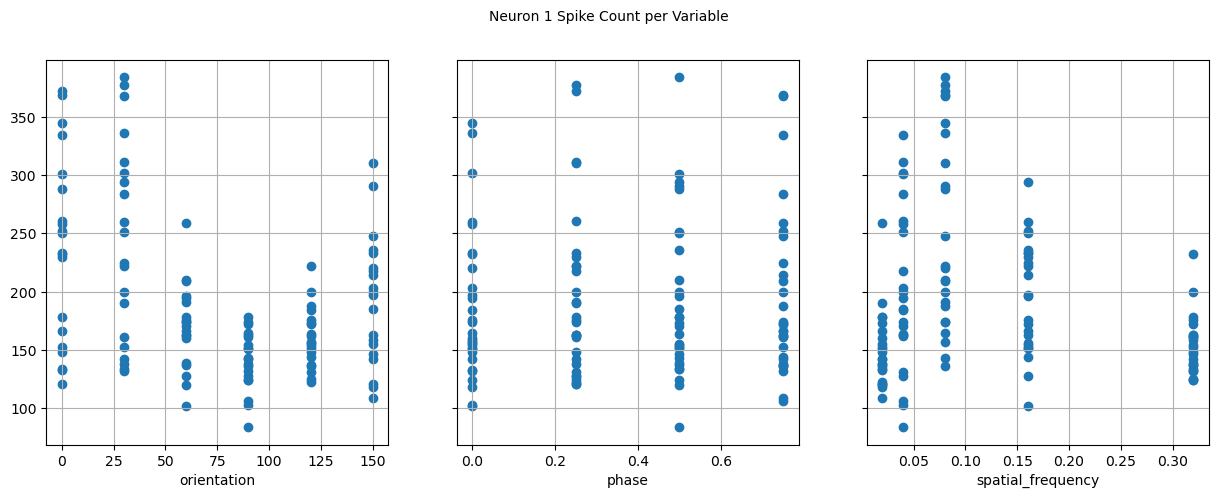

Neuron 2, Number of Samples: 120


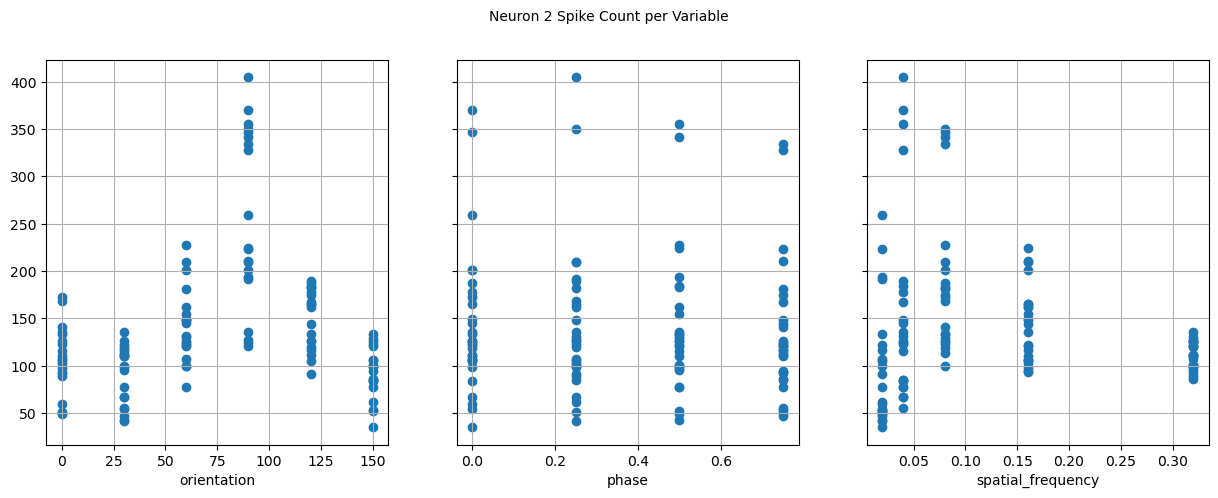

Neuron 3, Number of Samples: 120


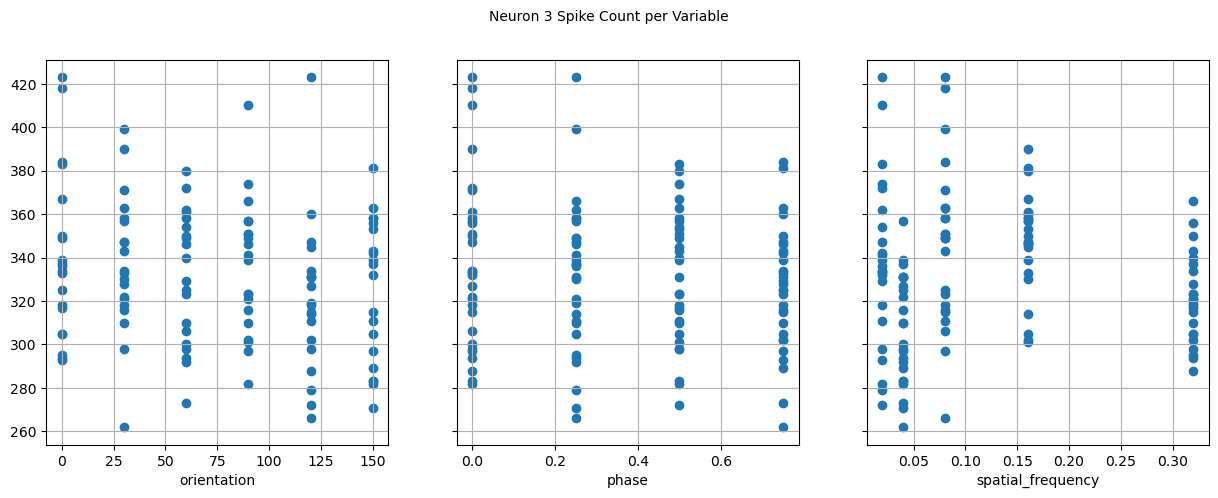

Neuron 4, Number of Samples: 120


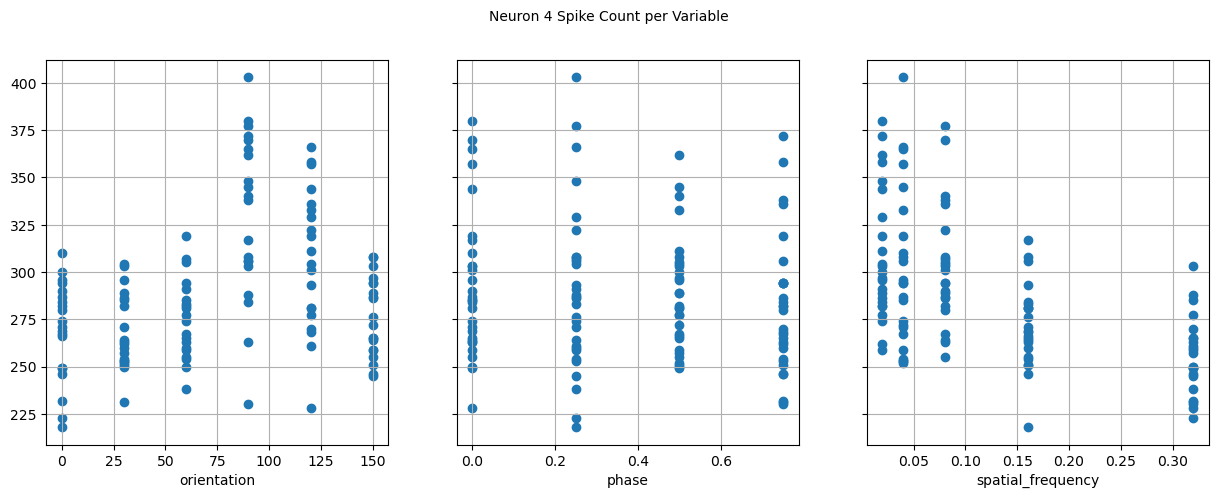

Neuron 5, Number of Samples: 120


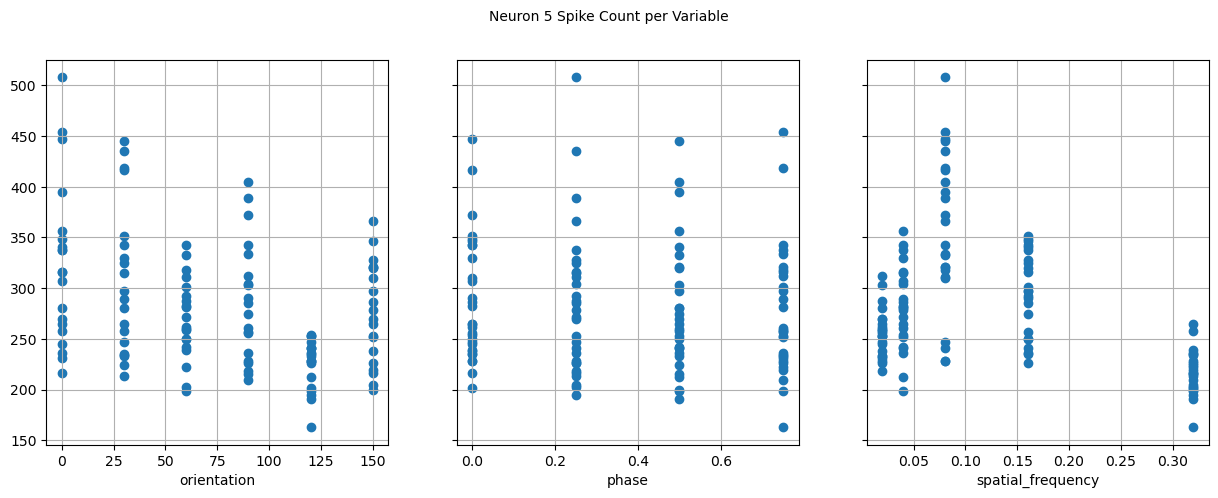

In [9]:
for i in range(5):
    data = dfs[i]
    print(f"Neuron {i+1}, Number of Samples: {data.shape[0]}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig.suptitle(f'Neuron {i+1} Spike Count per Variable', fontsize=10)

    for j, col in enumerate(["orientation", "phase", "spatial_frequency"]):
        axes[j].scatter(data[col], data["spike_count"])
        axes[j].set_xlabel(col)
        axes[j].grid(True)
    plt.show()

So we have 120 trials for each neuron. 

Write what you see in the plots and get hypothesis.

# Methods

We'll adopt two approaches, working neuron by neuron:
- **Linear Regression**: we assume $$y=X\theta + \varepsilon$$ where $\varepsilon_i\overset{\text{i.i.d}}{\sim}N(0,1)$, $\theta$ is the vector of parameters we want to estimate, $X$ is our data and $y$ our target variable. We'll proceed in a step-down method if necessary, so doing the regression and then removing the covariate which is not statistically significant and then redoing the regression only on those that are stat. sign. We'll take different feature sets $X$ (linear, polynomial, sinusoidal) to account for the possible nonlinearity of the data.

- **Neural Network Regression**: we build a simple, shallow, nonlinear MLP. We'll use only the input data as is, without using higher-order features. This is because we want to explot the power of NNs without having the need to develop data pipilines to trasform the data.

**HYPOTHESES**:
- We expect linear features to perform poorly, since data is mostly nonlinear. Polynomial and sinusoidal may perform better. Notice that if we include high-order polynomials we can expect similar performance between polynomial and sinusoidal features since sin and cos functions can be approximated with polynomials (Taylor series) and viceversa (Fourier series).
- We expect the MLP to perform better than linear regression, since with MLP we're not constraining the nonlinearity of the data, but rather we're letting the network learn the best possible nonlinear function.
- We expect some neurons to have no correlation at all, given the results in plots above.

**NOTE**:
- Given the high complexity of the brain, we decide to consider a significance level of 0.1, to account for the difficulty of the measurements (low samples) and for the fact that the stimuli are discrete.
- It doesn't make sense to do cross-validation since there are no hyper-parameters to tune.

# Setup

In this sections we add some auxiliary functions for the MLP. No need to use GPU since it's quite small. We use hidden layers with size 64-128-256-512-1024-256-64, RMSE loss, AdamW with weight decay value 0.025 and LeakyReLU activation.

In [9]:
class MLP(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
        )

    def forward(self, X):
        return self.layers(X)

class RMSELoss(nn.Module):

    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps) # add epsilon to avoid problems with derivative at 0
        return loss

criterion = RMSELoss()

def create_mlp(input_size):
    """Create the instance of the MLP and optimizer

    Args:
        input_size (int): size of the input layer (depends on the data)

    Returns:
        tuple: MLP model and corresponding Adam optimizer
    """

    model = MLP(input_size)
    opt = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=0.025)

    return model, opt

def train(model, opt, train_dataloader, test_dataloader, epochs = 50):
    """
    Train the model
    """

    train_loss_epoch = []
    test_loss_epoch = []

    for epoch in range(epochs):

        model.train()
        epoch_train_loss = 0

        for x, y in train_dataloader:
            opt.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            opt.step()

            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_dataloader)
        train_loss_epoch.append(epoch_train_loss)

        model.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for x, y in test_dataloader:
                y_pred = model(x)
                loss = criterion(y_pred, y)
                epoch_test_loss += loss.item()
        epoch_test_loss /= len(test_dataloader)
        test_loss_epoch.append(epoch_test_loss)

        print(f"Epoch {epoch + 1}\tTrain loss: {epoch_train_loss}\tTest loss: {epoch_test_loss}")

    plt.plot(train_loss_epoch, label = "train")
    plt.plot(test_loss_epoch, label = "test")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid()
    plt.show()
    
def get_prediction_mlp(df, model, orientation, spatial_frequency, phase, order=1, size=0.3, sinusoidal=False, combined = False):
    """
    Function to get the prediction for the mlp in the right formats.

    Args:
        df (pandas.core.frame.DataFrame): Dataframe containing the features and the output variable, that are used for the scaling
        model (OLS object): model that we will use for the regression
        orientation(float): orientation of the grating
        spatial_frequency(float): spatial frequency of the grating
        phase(float): phase of the grating
        variables_to_keep(list): variables of the regression that we want to keep
        order (int, optional): Order of polynomial features. Defaults to 1.
        size (float, optional): Test size. Defaults to 0.3.
        sinusoidal (bool, optional): Whether to include sinusoidal features. Defaults to False.
        combined (bool, optional): Whether to include both polynomial and sinusoidal features. No need to specificy sinusoidal. Detaults to False.

    Returns:
        float: predicted value
    """

    #useful for scaling
    X1 = np.array(df[["orientation", "phase", "spatial_frequency"]])

    if sinusoidal:
        X_sin1 = np.apply_along_axis(lambda x: np.sin(x), 0, X1)
        X_cos1 = np.apply_along_axis(lambda x: np.cos(x), 0, X1)
        X_feat1 = np.hstack((X_sin1, X_cos1))
    elif combined:
        X_sin1 = np.apply_along_axis(lambda x: np.sin(x), 0, X1)
        X_cos1 = np.apply_along_axis(lambda x: np.cos(x), 0, X1)
        poly_features = preprocessing.PolynomialFeatures(order, include_bias=False)
        X_poly1 = poly_features.fit_transform(X1)
        X_feat1 = np.hstack((X_poly1, X_sin1, X_cos1))
    else:
        poly_features = preprocessing.PolynomialFeatures(order, include_bias=False)
        X_feat1 = poly_features.fit_transform(X1)

    scaler = preprocessing.StandardScaler()
    X_feat_norm = scaler.fit_transform(X_feat1)

    #actual prediction
    X = np.array([[orientation, phase, spatial_frequency]])
    bias = np.ones((X.shape[0], 1))

    if sinusoidal:
        X_sin = np.apply_along_axis(lambda x: np.sin(x), 0, X)
        X_cos = np.apply_along_axis(lambda x: np.cos(x), 0, X)
        X_feat = np.hstack((X_sin, X_cos))
    elif combined:
        X_sin = np.apply_along_axis(lambda x: np.sin(x), 0, X)
        X_cos = np.apply_along_axis(lambda x: np.cos(x), 0, X)
        X_poly = poly_features.transform(X)
        X_feat = np.hstack((X_poly, X_sin, X_cos))
    else:
        X_feat = poly_features.transform(X)

    X_feat_norm = scaler.transform(X_feat)
    X_final = np.hstack((bias, X_feat_norm))

    prediction = model(torch.tensor(X_final, dtype = torch.float32)).item()

    return prediction

def run_mlp(df, epochs = 50):
    """
    Run an MLP with one function.

    Args:
        df (pandas.core.frame.DataFrame): Dataframe containing the features and the output variable
    """
    
    X_train_neuron, X_test_neuron, y_train_neuron, y_test_neuron = get_data(df)
    train_dataset, train_dataloader, test_dataset, test_dataloader = get_data_for_MLP(X_train_neuron, X_test_neuron, y_train_neuron, y_test_neuron)
    mlp_linear, opt = create_mlp(X_train_neuron.shape[1])
    train(mlp_linear, opt, train_dataloader, test_dataloader, epochs)
    
    return mlp_linear

def plot_regression_mlp_2D(df, model, var_to_plot1, var_to_plot2, order = 1, size = 0.3, sinusoidal = False, combined = False, orientation = 0, spatial_frequency = 0, phase = 0):
    # %matplotlib widget

    resolution = 50
    x = np.linspace(min(df[var_to_plot1]) - 0.1, max(df[var_to_plot1]) + 0.1, resolution)
    y = np.linspace(min(df[var_to_plot2]) - 0.1, max(df[var_to_plot2]) + 0.1, resolution)

    z = np.ones((1,len(x)))

    #get the predictions
    if var_to_plot1 == 'spatial_frequency':
        if var_to_plot2 == 'phase':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, orientation, j, i, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))
        if var_to_plot2 == 'orientation':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, i, j, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))
    if var_to_plot1 == 'phase':
        if var_to_plot2 == 'spatial_frequency':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, orientation, i, j, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))
        if var_to_plot2 == 'orientation':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, i, spatial_frequency, j, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))
    if var_to_plot1 == 'orientation':
        if var_to_plot2 == 'phase':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, j, spatial_frequency, i, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))
        if var_to_plot2 == 'spatial_frequency':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, j, i, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))

    z = z[1:,:]

    x, y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z)

    ax.scatter(df[var_to_plot1], df[var_to_plot2], df['spike_count'])

    ax.set_xlabel(var_to_plot1)
    ax.set_ylabel(var_to_plot2)
    ax.set_zlabel('spike count')
    ax.set_title('3D Surface Plot')

    plt.show()
    
def plot_regression_mlp_1D(df, model, var_to_plot, order = 1, size = 0.3, sinusoidal = False, combined = False, orientation = 0, spatial_frequency = 0, phase = 0):
    plt.clf()
    %matplotlib inline

    fig, ax = plt.subplots(figsize=(7, 5))

    x = np.linspace(min(df[var_to_plot]) - 0.1, max(df[var_to_plot]) + 0.1, 10)

    y = []
    if var_to_plot == 'spatial_frequency':
        for i in x:
            y.append(get_prediction_mlp(df, model, orientation, i, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
    if var_to_plot == 'orientation':
        for i in x:
            y.append(get_prediction_mlp(df, model, i, spatial_frequency, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
    if var_to_plot == 'phase':
        for i in x:
            y.append(get_prediction_mlp(df, model, orientation, spatial_frequency, i, order = order, size = size, sinusoidal=sinusoidal, combined = combined))


    ax.plot(x, y, "r--.", linewidth=2, label="MLP")

    #scatter points
    x = df[var_to_plot]
    y = df['spike_count']
    ax.plot(x, y, "o", label="data")

    ax.set_xlabel(var_to_plot, fontsize=12)
    ax.set_ylabel("Spike Count", fontsize=12)
    ax.set_title("Fitted Model by MLP", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(loc="best", fontsize=8)
    ax.grid(True)

    plt.show()

def plot_regression_mlp_1D_all(df, model, order = 1, size = 0.3, sinusoidal = False, combined = False, orientation = 0, spatial_frequency = 0, phase = 0):
    plt.clf()
    %matplotlib inline

    fig, ax = plt.subplots(1,3,figsize=(21, 5))
    count = 0
    for var_to_plot in ['orientation', 'spatial_frequency', 'phase']:
        x = np.linspace(min(df[var_to_plot]) - 0.1, max(df[var_to_plot]) + 0.1, 10)

        y = []
        if var_to_plot == 'spatial_frequency':
            for i in x:
                y.append(get_prediction_mlp(df, model, orientation, i, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
        if var_to_plot == 'orientation':
            for i in x:
                y.append(get_prediction_mlp(df, model, i, spatial_frequency, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
        if var_to_plot == 'phase':
            for i in x:
                y.append(get_prediction_mlp(df, model, orientation, spatial_frequency, i, order = order, size = size, sinusoidal=sinusoidal, combined = combined))


        ax[count].plot(x, y, "r--.", linewidth=2, label="MLP")

        #scatter points
        x = df[var_to_plot]
        y = df['spike_count']
        ax[count].plot(x, y, "o", label="data")

        ax[count].set_xlabel(var_to_plot, fontsize=12)
        ax[count].set_ylabel("Spike Count", fontsize=12)
        ax[count].set_title("Fitted Model by MLP", fontsize=14)
        ax[count].tick_params(axis='both', which='major', labelsize=12)
        ax[count].legend(loc="best", fontsize=8)
        ax[count].grid(True)

        count = count + 1

    plt.show()

# Neuron 1


In [11]:
df_neuron1 = dfs[0]
df_neuron1

unit_id  spike_count  orientation  phase  spatial_frequency
0    951092437          155        150.0   0.50               0.02
5    951092437          250          0.0   0.50               0.16
10   951092437          311         30.0   0.25               0.04
15   951092437          174         60.0   0.75               0.04
20   951092437          174         60.0   0.00               0.08
..         ...          ...          ...    ...                ...
580  951092437          142        150.0   0.25               0.32
585  951092437           84         90.0   0.50               0.04
590  951092437          233          0.0   0.00               0.16
595  951092437          134         30.0   0.50               0.32
600  951092437          138         90.0   0.25               0.02

[120 rows x 5 columns]

## MLP

c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Epoch 1	Train loss: 205.92302703857422	Test loss: 201.99447631835938
Epoch 2	Train loss: 203.97501373291016	Test loss: 201.91848754882812
Epoch 3	Train loss: 206.65853118896484	Test loss: 201.79498291015625
Epoch 4	Train loss: 198.45113372802734	Test loss: 201.52545166015625
Epoch 5	Train loss: 201.43032836914062	Test loss: 200.84803771972656
Epoch 6	Train loss: 205.16336822509766	Test loss: 199.03167724609375
Epoch 7	Train loss: 189.44046020507812	Test loss: 194.1915283203125
Epoch 8	Train loss: 195.4411849975586	Test loss: 181.86627197265625
Epoch 9	Train loss: 178.2551727294922	Test loss: 152.22494506835938
Epoch 10	Train loss: 136.05799102783203	Test loss: 90.78536224365234
Epoch 11	Train loss: 88.47513198852539	Test loss: 121.78983306884766
Epoch 12	Train loss: 131.4812469482422	Test loss: 85.04479217529297
Epoch 13	Train loss: 85.81180953979492	Test loss: 72.73943328857422
Epoch 14	Train loss: 78.42520141601562	Test loss: 89.33870697021484
Epoch 15	Train loss: 97.79984283447266	T

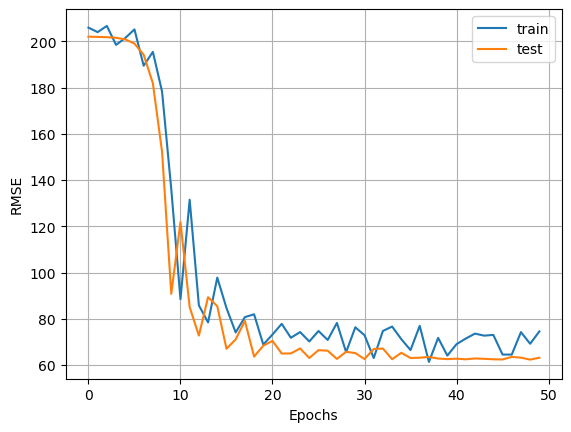

In [15]:
mlp_linear = run_mlp(df_neuron1)

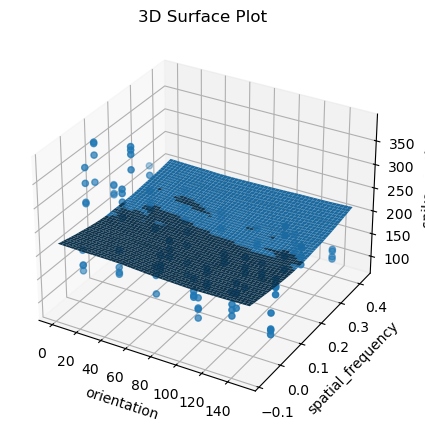

In [16]:
plot_regression_mlp_2D(df_neuron1, mlp_linear, 'orientation', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

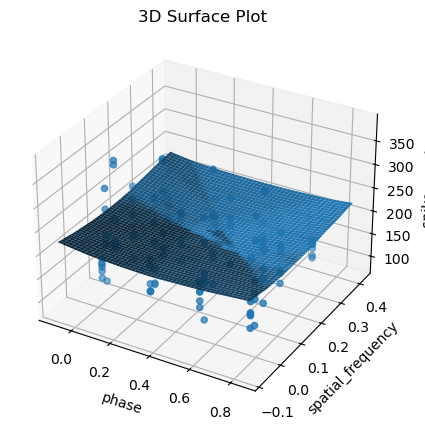

In [17]:
plot_regression_mlp_2D(df_neuron1, mlp_linear, 'phase', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

<Figure size 640x480 with 0 Axes>

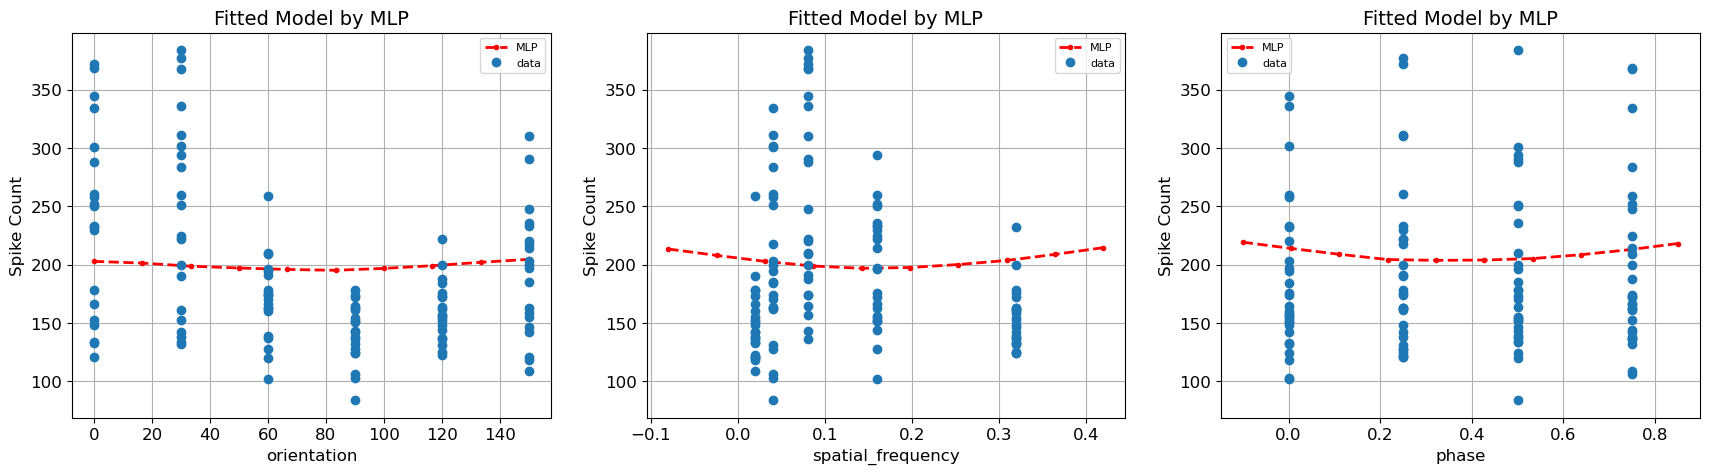

In [18]:
plot_regression_mlp_1D_all(df_neuron1, mlp_linear, orientation = 150, phase = 0.5, spatial_frequency= 0.32)

## Linear Regression

### First-Order Features

In [12]:
X_train_neuron1, X_test_neuron1, y_train_neuron1, y_test_neuron1 = get_data(df_neuron1)

In [13]:
res_order1 = OLS(y_train_neuron1, X_train_neuron1).fit()
print(res_order1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5.627
Date:                Tue, 30 Apr 2024   Prob (F-statistic):            0.00150
Time:                        23:23:38   Log-Likelihood:                -467.49
No. Observations:                  84   AIC:                             943.0
Df Residuals:                      80   BIC:                             952.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        189.2573      7.091     26.690      0.0

Here $x_2$ is not statistically significant. We remove it and apply step-down.

In [14]:
final_features = backward_elimination(y_train_neuron1, X_train_neuron1)
print(f"Final model with significant features: {final_features}")
res_order1_improved = OLS(y_train_neuron1, X_train_neuron1[:, final_features]).fit()
print(res_order1_improved.summary())

Final model with significant features: [0, 1, 3]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     8.433
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           0.000471
Time:                        23:23:44   Log-Likelihood:                -467.59
No. Observations:                  84   AIC:                             941.2
Df Residuals:                      81   BIC:                             948.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

R Squared: 0.172, Adjusted R Squared 0.152
Train RMSE: 69.974
Test RMSE: 58.346


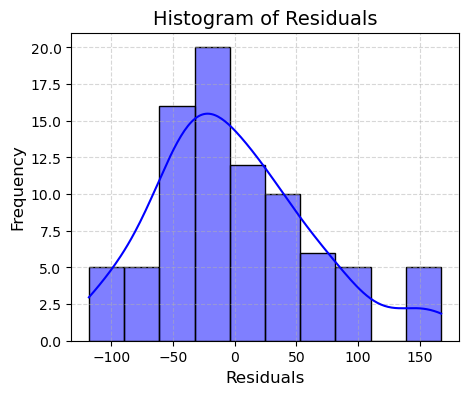

Final equation --> y = 189.41 + -23.61 * orient + -15.94 * freq


In [15]:
summary(res_order1_improved, final_features, X_test_neuron1, y_test_neuron1)

<Figure size 640x480 with 0 Axes>

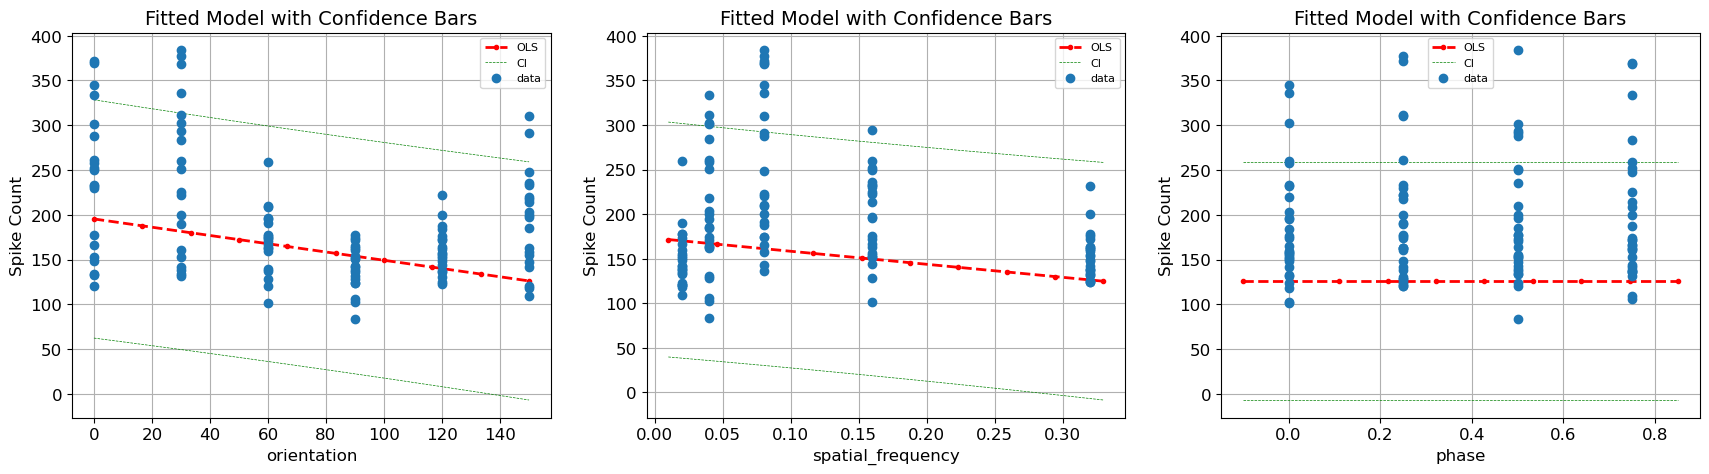

In [16]:
plot_regression_1D_all(df_neuron1, res_order1_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5)

Clearly not ideal.

### Quadratic Features

The covariates are $x_1,x_2,x_3,x_1^2, x_1x_2,x_1x_3,x_2^2,x_2x_3,x_3^2$ and the bias. We expect improvements, also given the insights of the output of the MLP.

In [17]:
X_train_neuron1, X_test_neuron1, y_train_neuron1, y_test_neuron1 = get_data(df_neuron1, order=2)

In [18]:
res_order2 = OLS(y_train_neuron1, X_train_neuron1).fit()
print(res_order2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     6.060
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           2.47e-06
Time:                        23:23:54   Log-Likelihood:                -452.34
No. Observations:                  84   AIC:                             924.7
Df Residuals:                      74   BIC:                             949.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        187.9118      6.188     30.366      0.0

We need to do model selection. Let's apply step-down.

In [19]:
final_features = backward_elimination(y_train_neuron1, X_train_neuron1)
print(f"Final model with significant features: {final_features}")
res_order2_improved = OLS(y_train_neuron1, X_train_neuron1[:, final_features]).fit()
print(res_order2_improved.summary())

Final model with significant features: [0, 1, 3, 4, 9]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     12.84
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           4.26e-08
Time:                        23:23:56   Log-Likelihood:                -454.50
No. Observations:                  84   AIC:                             919.0
Df Residuals:                      79   BIC:                             931.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.394, Adjusted R Squared 0.363
Train RMSE: 69.974
Test RMSE: 48.821


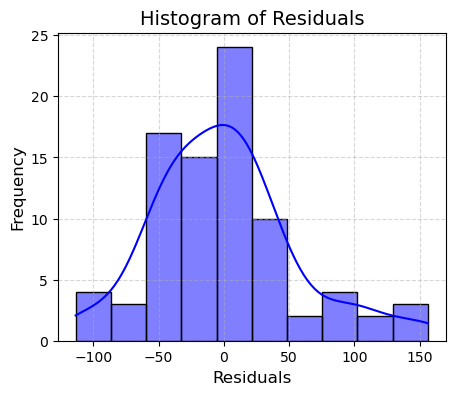

Final equation --> y = 189.07 + -86.86 * orient + 104.79 * freq + 66.83 * orient^2 + -122.02 * freq^2


In [20]:
summary(res_order2_improved, final_features, X_test_neuron1, y_test_neuron1)

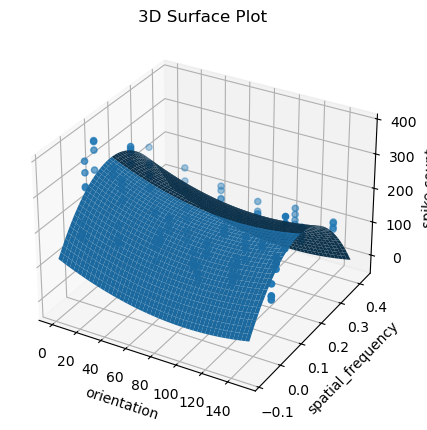

In [21]:
plot_regression_2D(df_neuron1, res_order2_improved, 'orientation', 'spatial_frequency', final_features, order = 2, phase = 0.5)

<Figure size 640x480 with 0 Axes>

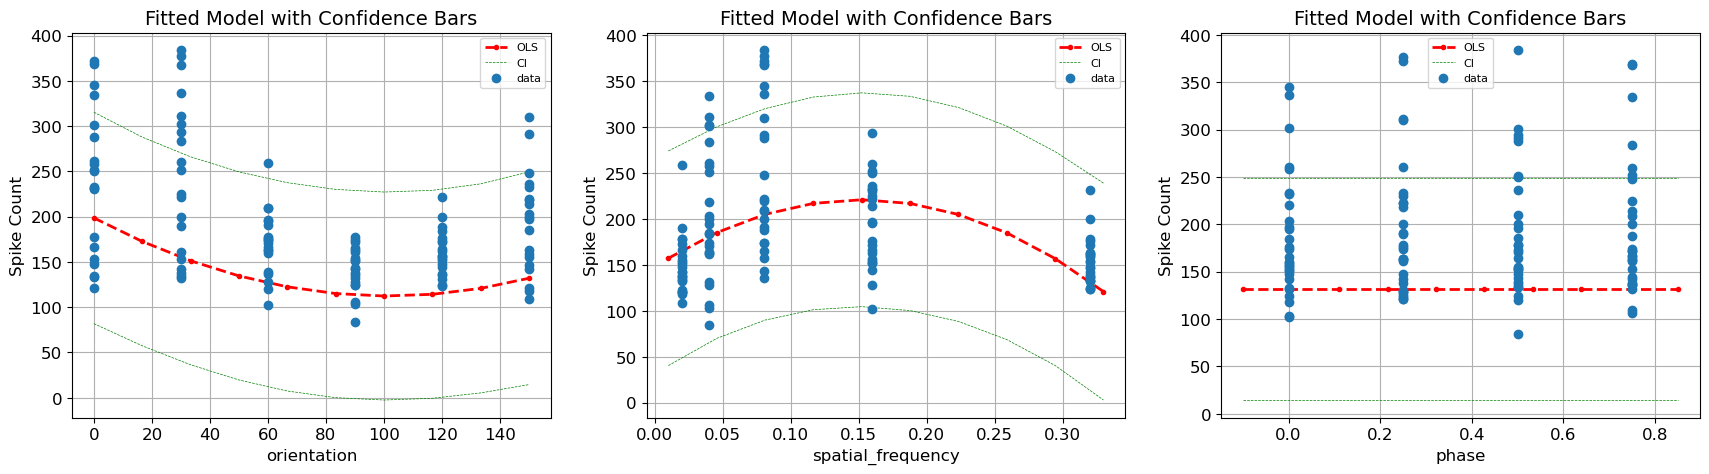

In [22]:
plot_regression_1D_all(df_neuron1, res_order2_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Sinusoidal Features

Here we have $\sin x_1, \sin x_2,\sin x_3, \cos x_1, \cos x_2,\cos x_3$ and the bias.

In [23]:
X_train_neuron1, X_test_neuron1, y_train_neuron1, y_test_neuron1 = get_data(df_neuron1, sinusoidal=True)

In [24]:
res_sinusoidal = OLS(y_train_neuron1, X_train_neuron1).fit()
print(res_sinusoidal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     9.841
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           4.89e-08
Time:                        23:24:24   Log-Likelihood:                -451.62
No. Observations:                  84   AIC:                             917.2
Df Residuals:                      77   BIC:                             934.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.5400      6.007     31.886      0.0

Let's apply step-down

In [25]:
final_features = backward_elimination(y_train_neuron1, X_train_neuron1)
print(f"Final model with significant features: {final_features}")
res_sinusoidal_improved = OLS(y_train_neuron1, X_train_neuron1[:, final_features]).fit()
print(res_sinusoidal_improved.summary())

Final model with significant features: [0, 1, 3, 4, 6]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     14.08
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           1.02e-08
Time:                        23:24:25   Log-Likelihood:                -452.92
No. Observations:                  84   AIC:                             915.8
Df Residuals:                      79   BIC:                             928.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.416, Adjusted R Squared 0.387
Train RMSE: 69.974
Test RMSE: 54.102


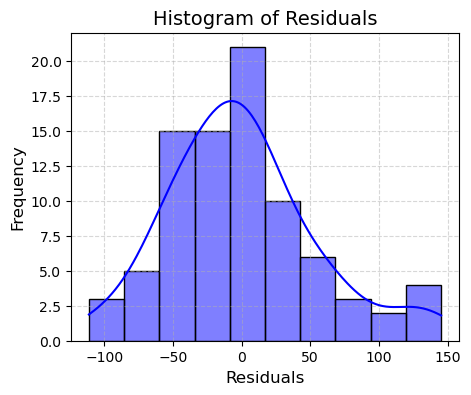

Final equation --> y = 192.30 + -27.26 * sin(orient) + 91.98 * sin(freq) + 14.49 * cos(orient) + 108.72 * cos(freq)


In [26]:
summary(res_sinusoidal_improved, final_features, X_test_neuron1, y_test_neuron1, sinusoidal = True)

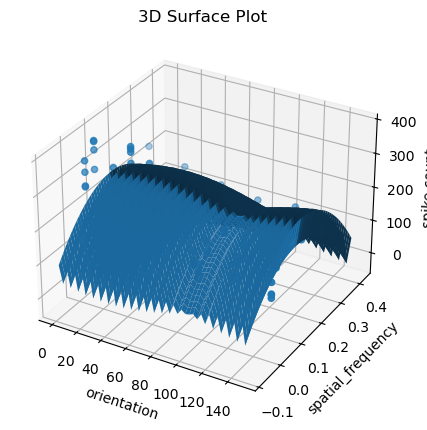

In [27]:
plot_regression_2D(df_neuron1, res_sinusoidal_improved, 'orientation', 'spatial_frequency', final_features, sinusoidal=True, phase = 0.5)

<Figure size 640x480 with 0 Axes>

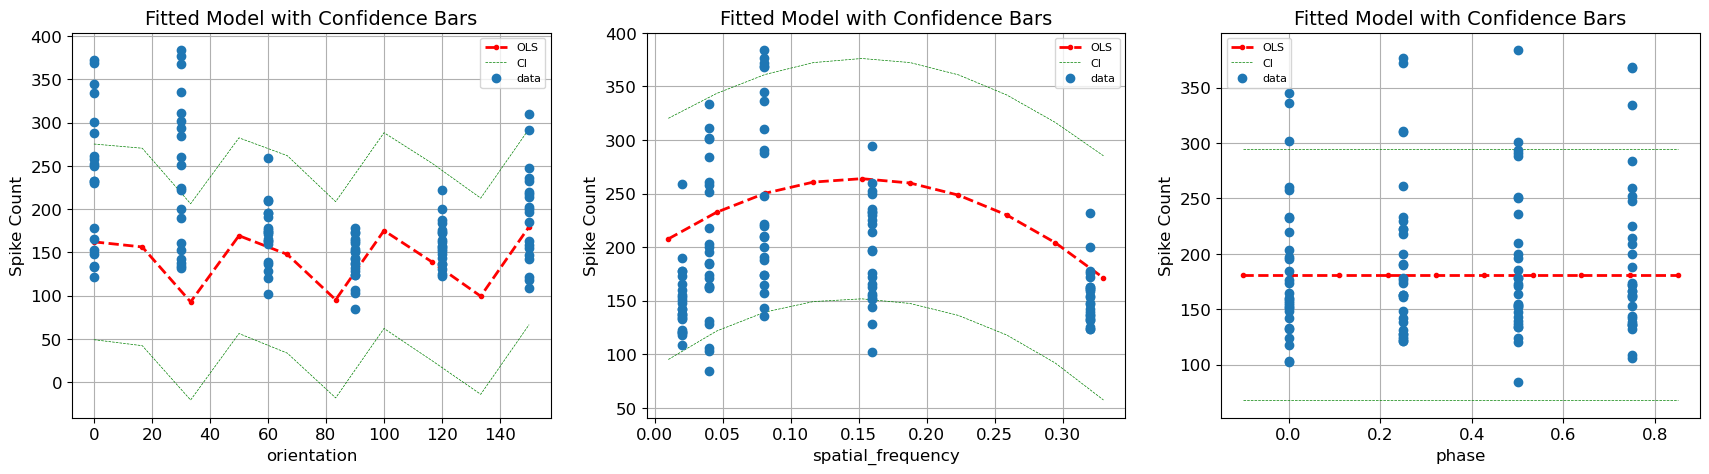

In [28]:
plot_regression_1D_all(df_neuron1, res_sinusoidal_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, sinusoidal=True)

### Combined Features

We use combined features, with second-order polynomials.

In [29]:
X_train_neuron1, X_test_neuron1, y_train_neuron1, y_test_neuron1 = get_data(df_neuron1, order=2, combined=True)

In [30]:
res_combined = OLS(y_train_neuron1, X_train_neuron1).fit()
print(res_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     10.62
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           2.76e-12
Time:                        23:24:47   Log-Likelihood:                -427.26
No. Observations:                  84   AIC:                             884.5
Df Residuals:                      69   BIC:                             921.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        188.5679      4.780     39.448      0.0

In [31]:
final_features = backward_elimination(y_train_neuron1, X_train_neuron1)
print(f"Final model with significant features: {final_features}")
res_combined_improved = OLS(y_train_neuron1, X_train_neuron1[:, final_features]).fit()
print(res_combined_improved.summary())

Final model with significant features: [0, 3, 4, 6, 9, 10, 12, 13]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     21.32
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           1.30e-15
Time:                        23:24:48   Log-Likelihood:                -429.90
No. Observations:                  84   AIC:                             875.8
Df Residuals:                      76   BIC:                             895.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

R Squared: 0.663, Adjusted R Squared 0.632
Train RMSE: 69.974
Test RMSE: 41.440


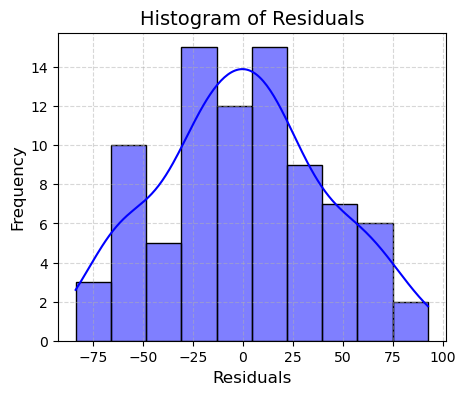

Final equation --> y = 189.57 + 44407.51 * freq + -30.94 * orient^2 + 17.31 * (orient * freq) + -1377.48 * freq^2 + -26.22 * sin(orient) + -43090.47 * sin(freq) + 21.86 * cos(orient)


In [32]:
summary(res_combined_improved, final_features, X_test_neuron1, y_test_neuron1)

<Figure size 640x480 with 0 Axes>

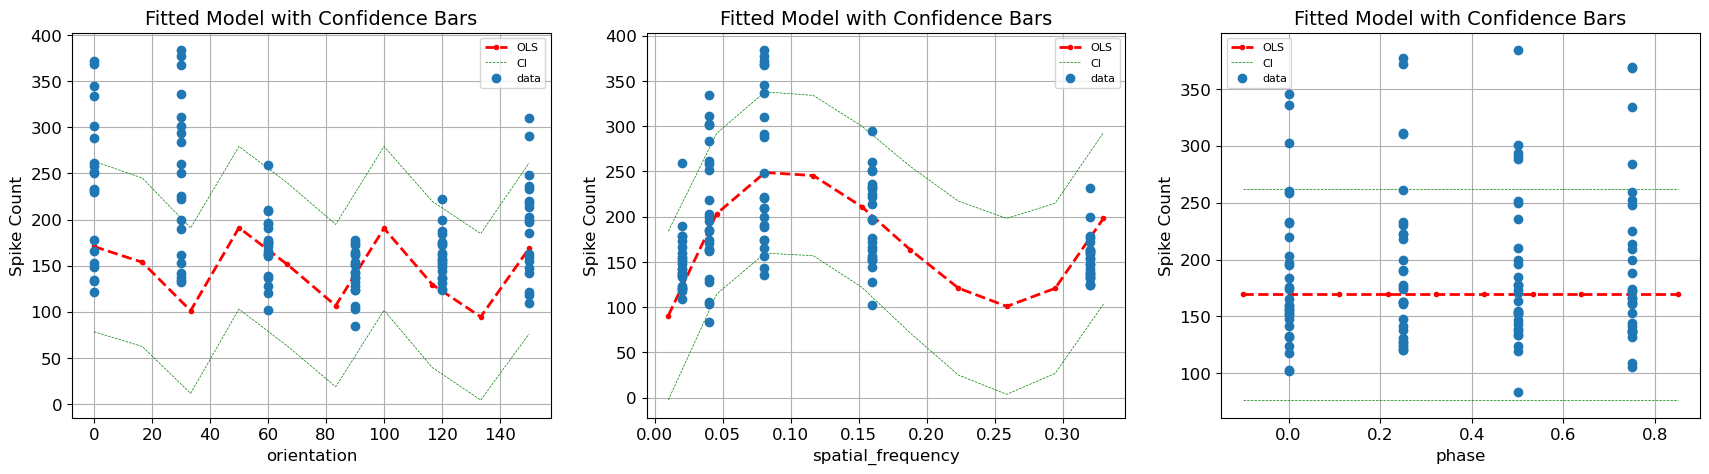

In [33]:
plot_regression_1D_all(df_neuron1, res_combined_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, combined=True, order = 2)

# Neuron 2

In [34]:
df_neuron2 = dfs[1]
df_neuron2

unit_id  spike_count  orientation  phase  spatial_frequency
1    951092798           52        150.0   0.50               0.02
6    951092798           97          0.0   0.50               0.16
11   951092798           67         30.0   0.25               0.04
16   951092798          124         60.0   0.75               0.04
21   951092798          201         60.0   0.00               0.08
..         ...          ...          ...    ...                ...
581  951092798          100        150.0   0.25               0.32
586  951092798          355         90.0   0.50               0.04
591  951092798          106          0.0   0.00               0.16
596  951092798           95         30.0   0.50               0.32
601  951092798          192         90.0   0.25               0.02

[120 rows x 5 columns]

## MLP

c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Epoch 1	Train loss: 158.05631256103516	Test loss: 150.9376220703125
Epoch 2	Train loss: 149.88888549804688	Test loss: 150.86878967285156
Epoch 3	Train loss: 149.04869842529297	Test loss: 150.76011657714844
Epoch 4	Train loss: 170.0244598388672	Test loss: 150.5302276611328
Epoch 5	Train loss: 164.85601043701172	Test loss: 149.9669647216797
Epoch 6	Train loss: 161.49212646484375	Test loss: 148.47506713867188
Epoch 7	Train loss: 156.8434295654297	Test loss: 144.51271057128906
Epoch 8	Train loss: 155.0549545288086	Test loss: 134.38238525390625
Epoch 9	Train loss: 144.7382583618164	Test loss: 110.7554702758789
Epoch 10	Train loss: 118.1225471496582	Test loss: 72.36634826660156
Epoch 11	Train loss: 83.81282806396484	Test loss: 102.56304931640625
Epoch 12	Train loss: 102.92893981933594	Test loss: 73.78494262695312
Epoch 13	Train loss: 76.98055267333984	Test loss: 71.58937072753906
Epoch 14	Train loss: 81.66178131103516	Test loss: 75.10821533203125
Epoch 15	Train loss: 85.40539932250977	Test l

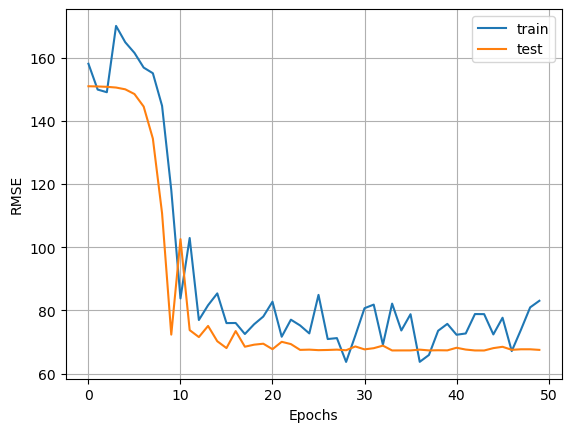

In [35]:
mlp_linear = run_mlp(df_neuron2)

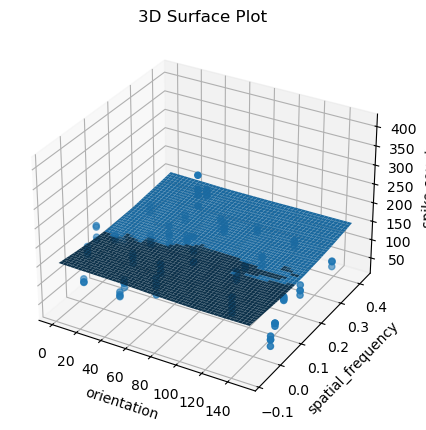

In [36]:
plot_regression_mlp_2D(df_neuron2, mlp_linear, 'orientation', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

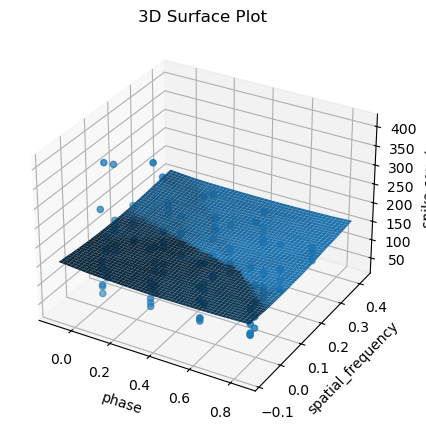

In [37]:
plot_regression_mlp_2D(df_neuron2, mlp_linear, 'phase', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

<Figure size 640x480 with 0 Axes>

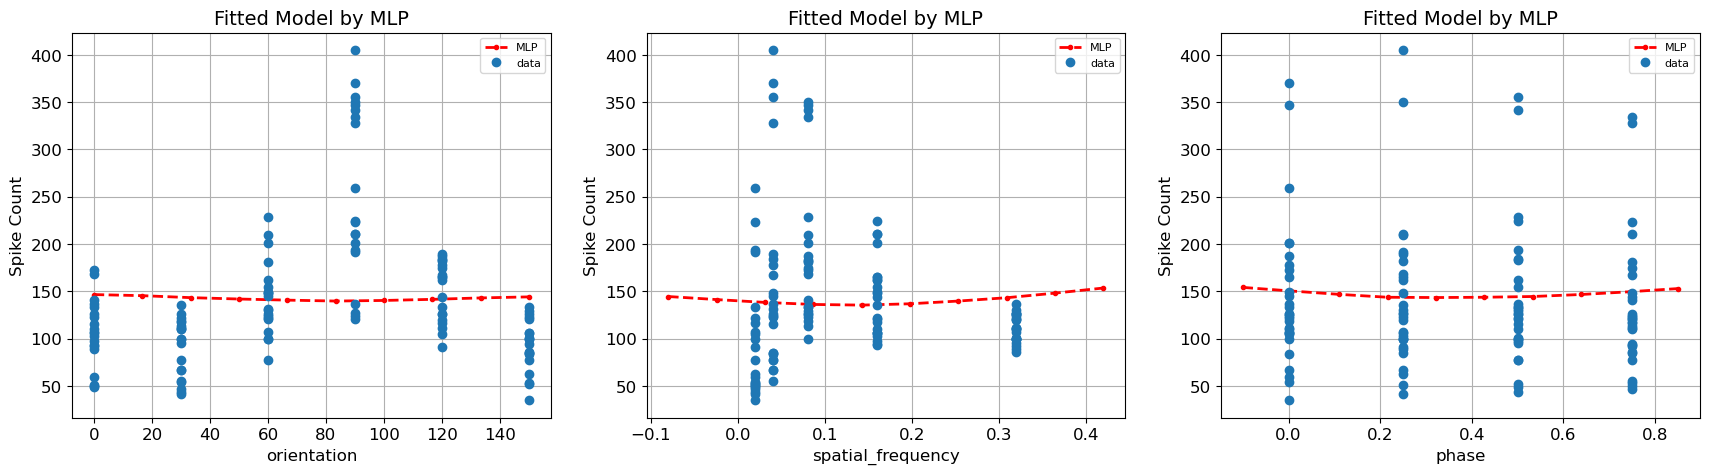

In [38]:
plot_regression_mlp_1D_all(df_neuron2, mlp_linear, orientation = 150, phase = 0.5, spatial_frequency= 0.32)

## Linear Regression

### First-Order Features

In [39]:
X_train_neuron2, X_test_neuron2, y_train_neuron2, y_test_neuron2 = get_data(df_neuron2)
res_order1 = OLS(y_train_neuron2, X_train_neuron2).fit()
print(res_order1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.915
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.134
Time:                        23:25:20   Log-Likelihood:                -479.45
No. Observations:                  84   AIC:                             966.9
Df Residuals:                      80   BIC:                             976.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        142.3476      8.176     17.411      0.0

In [40]:
final_features = backward_elimination(y_train_neuron2, X_train_neuron2)
print(f"Final model with significant features: {final_features}")
res_order1_improved = OLS(y_train_neuron2, X_train_neuron2[:, final_features]).fit()
print(res_order1_improved.summary())

Final model with significant features: [0, 1]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.167
Date:                Tue, 30 Apr 2024   Prob (F-statistic):             0.0444
Time:                        23:25:20   Log-Likelihood:                -480.28
No. Observations:                  84   AIC:                             964.6
Df Residuals:                      82   BIC:                             969.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

R Squared: 0.048, Adjusted R Squared 0.037
Train RMSE: 75.899
Test RMSE: 70.076


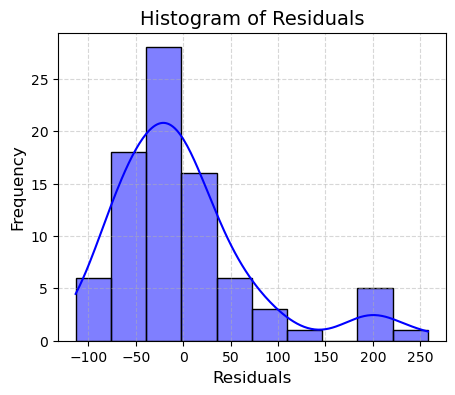

Final equation --> y = 142.06 + 16.69 * orient


In [41]:
summary(res_order1_improved, final_features, X_test_neuron2, y_test_neuron2)

<Figure size 640x480 with 0 Axes>

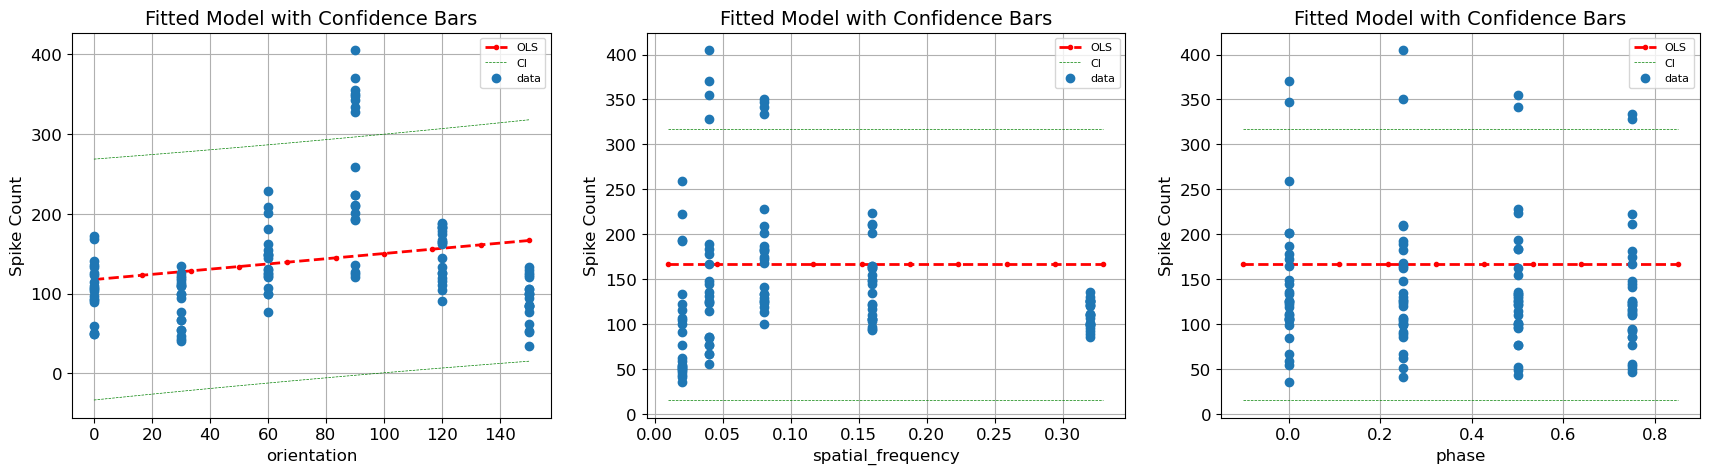

In [42]:
plot_regression_1D_all(df_neuron2, res_order1_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5)

### Quadratic Features

In [43]:
X_train_neuron2, X_test_neuron2, y_train_neuron2, y_test_neuron2 = get_data(df_neuron2, order = 2)
res_order2 = OLS(y_train_neuron2, X_train_neuron2).fit()
print(res_order2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     5.921
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           3.39e-06
Time:                        23:25:23   Log-Likelihood:                -459.58
No. Observations:                  84   AIC:                             939.2
Df Residuals:                      74   BIC:                             963.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.8729      6.745     20.885      0.0

Apply step-down

In [44]:
final_features = backward_elimination(y_train_neuron2, X_train_neuron2)
print(f"Final model with significant features: {final_features}")
res_order2_improved = OLS(y_train_neuron2, X_train_neuron2[:, final_features]).fit()
print(res_order2_improved.summary())

Final model with significant features: [0, 1, 3, 4, 9]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     12.51
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           6.22e-08
Time:                        23:25:24   Log-Likelihood:                -461.75
No. Observations:                  84   AIC:                             933.5
Df Residuals:                      79   BIC:                             945.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.388, Adjusted R Squared 0.357
Train RMSE: 75.899
Test RMSE: 57.623


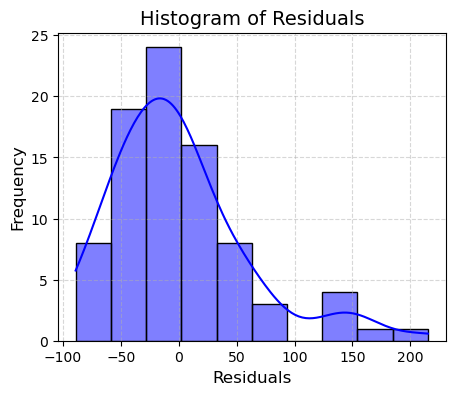

Final equation --> y = 141.23 + 146.19 * orient + 59.97 * freq + -139.62 * orient^2 + -74.13 * freq^2


In [45]:
summary(res_order2_improved, final_features, X_test_neuron2, y_test_neuron2)

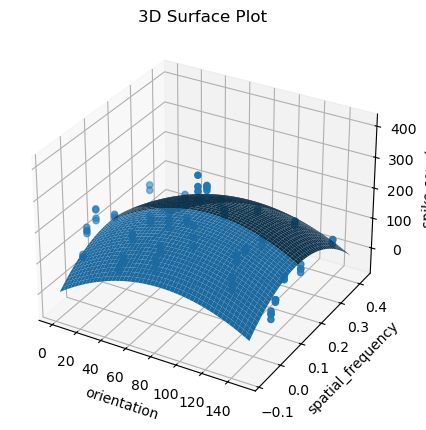

In [46]:
plot_regression_2D(df_neuron2, res_order2_improved, 'orientation', 'spatial_frequency', final_features, order = 2, phase = 0.5)

<Figure size 640x480 with 0 Axes>

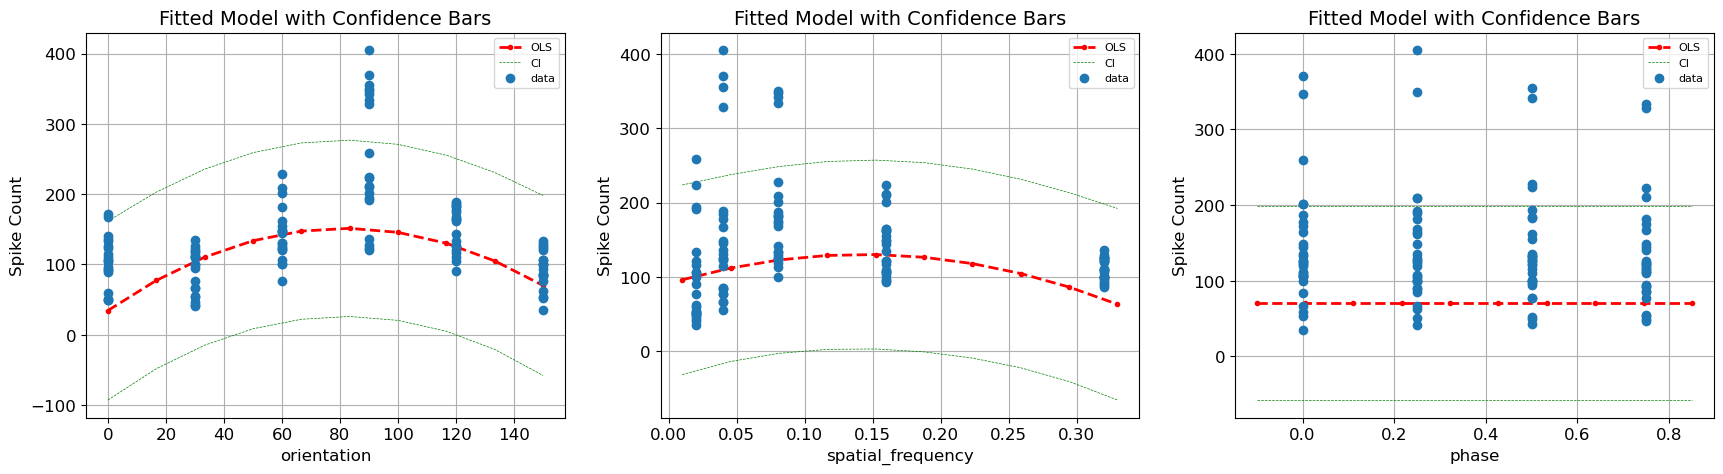

In [47]:
plot_regression_1D_all(df_neuron2, res_order2_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Sinusoidal Features

In [48]:
X_train_neuron2, X_test_neuron2, y_train_neuron2, y_test_neuron2 = get_data(df_neuron2, sinusoidal=True)
res_sinusoidal = OLS(y_train_neuron2, X_train_neuron2).fit()
print(res_sinusoidal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     23.39
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           1.53e-15
Time:                        23:25:37   Log-Likelihood:                -438.78
No. Observations:                  84   AIC:                             891.6
Df Residuals:                      77   BIC:                             908.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        137.1501      5.155     26.605      0.0

Apply step-down

In [49]:
final_features = backward_elimination(y_train_neuron2, X_train_neuron2)
print(f"Final model with significant features: {final_features}")
res_sinusoidal_improved = OLS(y_train_neuron2, X_train_neuron2[:, final_features]).fit()
print(res_sinusoidal_improved.summary())

Final model with significant features: [0, 1, 3, 4, 6]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     33.76
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           2.07e-16
Time:                        23:25:39   Log-Likelihood:                -440.50
No. Observations:                  84   AIC:                             891.0
Df Residuals:                      79   BIC:                             903.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.631, Adjusted R Squared 0.612
Train RMSE: 75.899
Test RMSE: 45.219


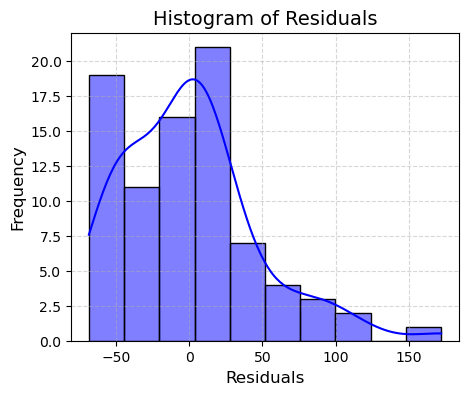

Final equation --> y = 137.55 + 45.94 * sin(orient) + 71.90 * sin(freq) + -27.10 * cos(orient) + 87.30 * cos(freq)


In [50]:
summary(res_sinusoidal_improved, final_features, X_test_neuron2, y_test_neuron2, sinusoidal=True)

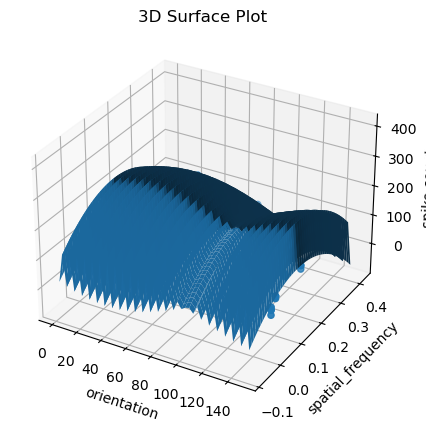

In [51]:
plot_regression_2D(df_neuron2, res_sinusoidal_improved, 'orientation', 'spatial_frequency', final_features, sinusoidal=True, phase = 0.5)

<Figure size 640x480 with 0 Axes>

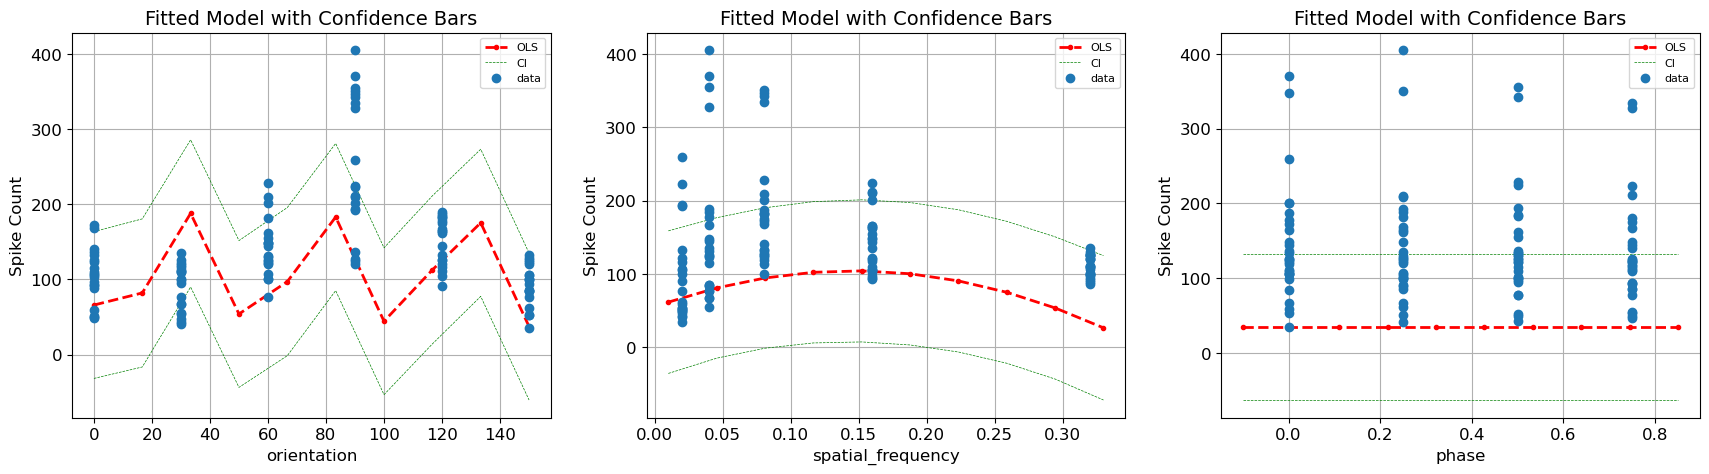

In [52]:
plot_regression_1D_all(df_neuron2, res_sinusoidal_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, sinusoidal=True)

### Combined Features

In [53]:
X_train_neuron2, X_test_neuron2, y_train_neuron2, y_test_neuron2 = get_data(df_neuron2, order=2, combined=True)
res_combined = OLS(y_train_neuron2, X_train_neuron2).fit()
print(res_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     15.12
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           7.71e-16
Time:                        23:25:52   Log-Likelihood:                -423.43
No. Observations:                  84   AIC:                             876.9
Df Residuals:                      69   BIC:                             913.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        137.3214      4.567     30.067      0.0

Apply step-down

In [54]:
final_features = backward_elimination(y_train_neuron2, X_train_neuron2)
print(f"Final model with significant features: {final_features}")
res_combined_improved = OLS(y_train_neuron2, X_train_neuron2[:, final_features]).fit()
print(res_combined_improved.summary())

Final model with significant features: [0, 3, 9, 10, 12, 13]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     43.43
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           3.55e-21
Time:                        23:25:54   Log-Likelihood:                -426.47
No. Observations:                  84   AIC:                             864.9
Df Residuals:                      78   BIC:                             879.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

R Squared: 0.736, Adjusted R Squared 0.719
Train RMSE: 75.899
Test RMSE: 38.024


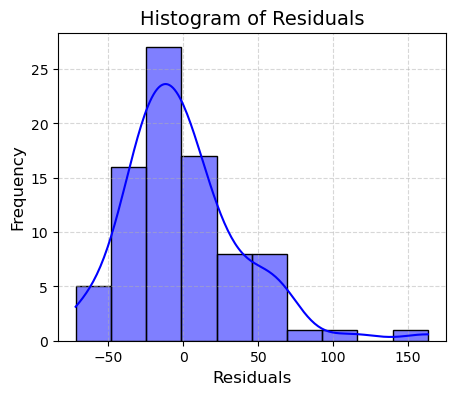

Final equation --> y = 136.78 + 39545.36 * freq + -1212.05 * freq^2 + 45.54 * sin(orient) + -38377.74 * sin(freq) + -26.66 * cos(orient)


In [55]:
summary(res_combined_improved, final_features, X_test_neuron2, y_test_neuron2)

<Figure size 640x480 with 0 Axes>

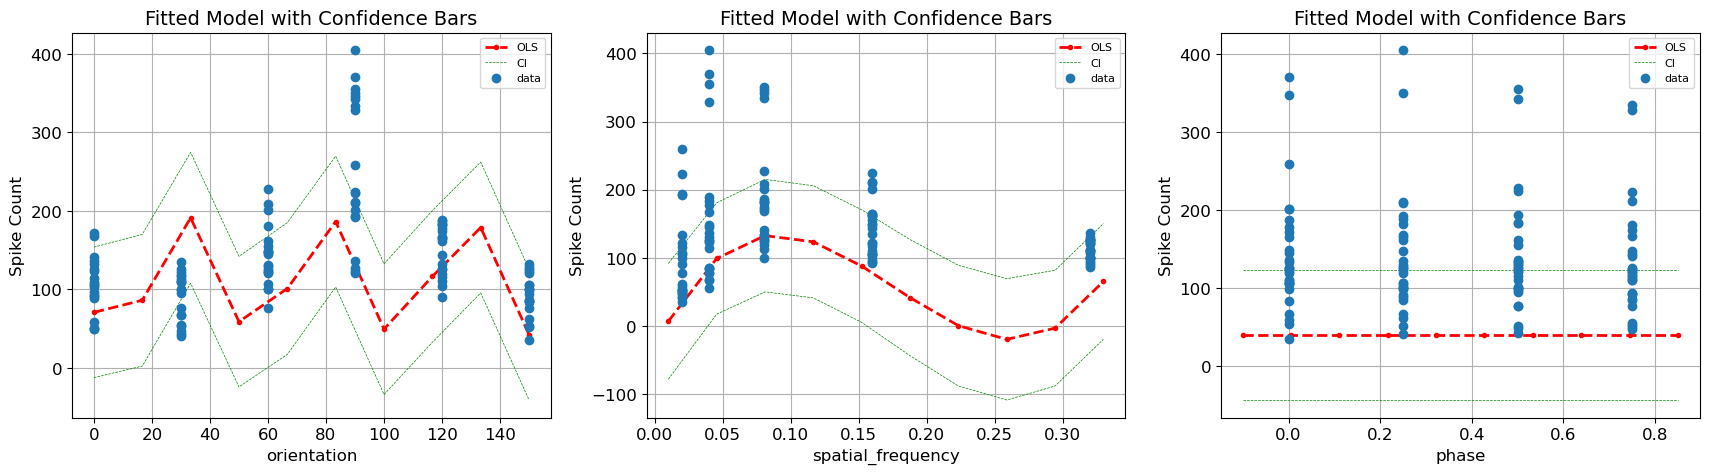

In [56]:
plot_regression_1D_all(df_neuron2, res_combined_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, combined=True, order = 2)

# Neuron 3

In [57]:
df_neuron3 = dfs[2]
df_neuron3

unit_id  spike_count  orientation  phase  spatial_frequency
2    951092940          282        150.0   0.50               0.02
7    951092940          367          0.0   0.50               0.16
12   951092940          310         30.0   0.25               0.04
17   951092940          273         60.0   0.75               0.04
22   951092940          306         60.0   0.00               0.08
..         ...          ...          ...    ...                ...
582  951092940          337        150.0   0.25               0.32
587  951092940          310         90.0   0.50               0.04
592  951092940          333          0.0   0.00               0.16
597  951092940          343         30.0   0.50               0.32
602  951092940          341         90.0   0.25               0.02

[120 rows x 5 columns]

## MLP

c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Epoch 1	Train loss: 334.6676483154297	Test loss: 332.0351867675781
Epoch 2	Train loss: 338.2631072998047	Test loss: 331.95208740234375
Epoch 3	Train loss: 332.70945739746094	Test loss: 331.8116455078125
Epoch 4	Train loss: 334.37925720214844	Test loss: 331.49493408203125
Epoch 5	Train loss: 333.6892395019531	Test loss: 330.6800231933594


Epoch 6	Train loss: 332.3323059082031	Test loss: 328.4786376953125
Epoch 7	Train loss: 329.65460205078125	Test loss: 322.61248779296875
Epoch 8	Train loss: 319.942138671875	Test loss: 307.7344970703125
Epoch 9	Train loss: 302.62660217285156	Test loss: 271.66827392578125
Epoch 10	Train loss: 259.52015686035156	Test loss: 189.8494110107422
Epoch 11	Train loss: 154.3017578125	Test loss: 65.85010528564453
Epoch 12	Train loss: 102.1791877746582	Test loss: 129.61264038085938
Epoch 13	Train loss: 105.35393905639648	Test loss: 49.318092346191406
Epoch 14	Train loss: 65.33740043640137	Test loss: 81.03504943847656
Epoch 15	Train loss: 81.94341659545898	Test loss: 60.39131546020508
Epoch 16	Train loss: 51.66082000732422	Test loss: 56.78522872924805
Epoch 17	Train loss: 61.806631088256836	Test loss: 65.98220825195312
Epoch 18	Train loss: 54.27700614929199	Test loss: 43.41929626464844
Epoch 19	Train loss: 54.037811279296875	Test loss: 53.21714401245117
Epoch 20	Train loss: 52.61863136291504	Test lo

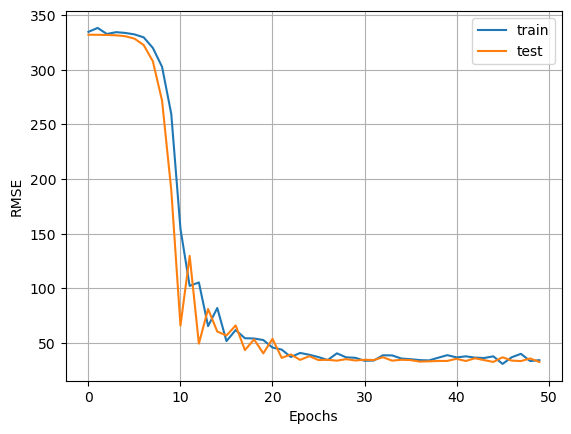

In [58]:
mlp_linear = run_mlp(df_neuron3)

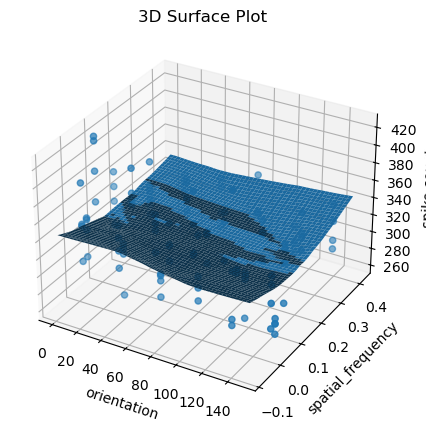

In [59]:
plot_regression_mlp_2D(df_neuron3, mlp_linear, 'orientation', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

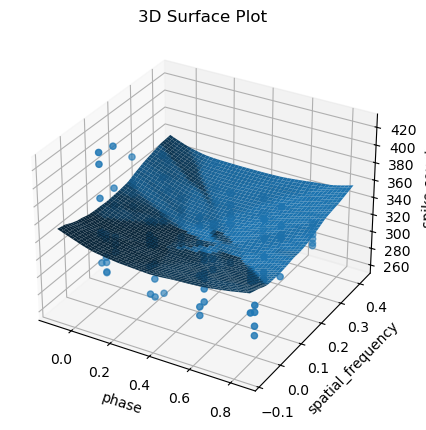

In [60]:
plot_regression_mlp_2D(df_neuron3, mlp_linear, 'phase', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

<Figure size 640x480 with 0 Axes>

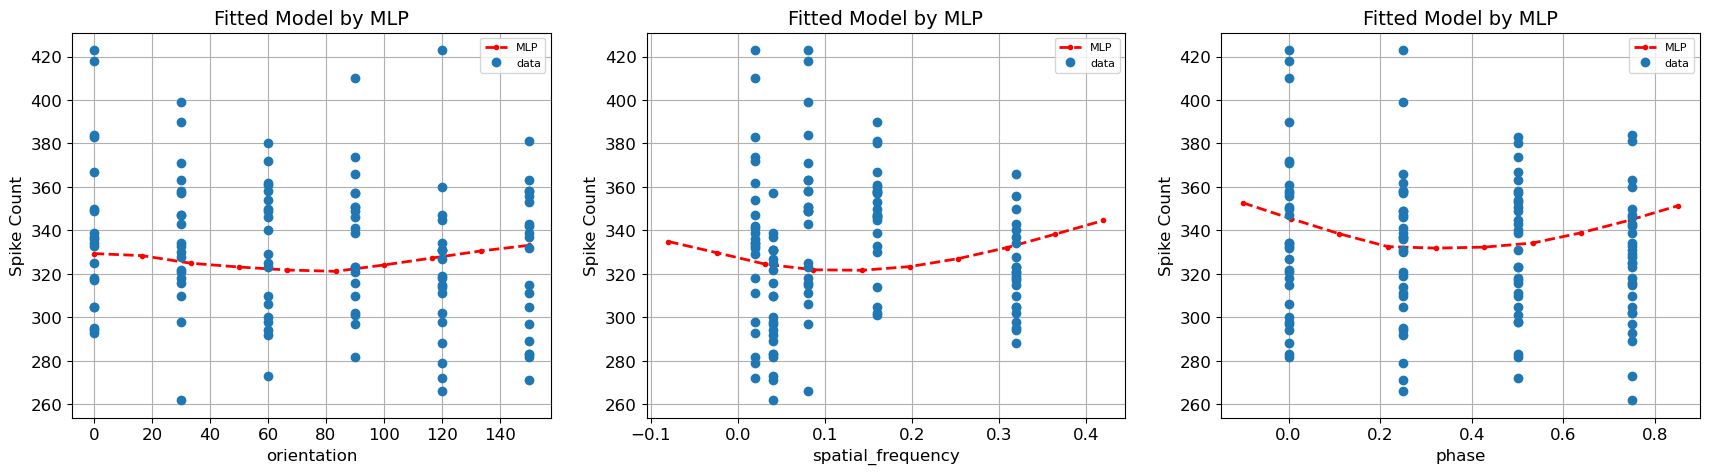

In [61]:
plot_regression_mlp_1D_all(df_neuron3, mlp_linear, orientation = 150, phase = 0.5, spatial_frequency= 0.32)

## Linear Regression

### First-Order Features

In [62]:
X_train_neuron3, X_test_neuron3, y_train_neuron3, y_test_neuron3 = get_data(df_neuron3)
res_order1 = OLS(y_train_neuron3, X_train_neuron3).fit()
print(res_order1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9080
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.441
Time:                        23:26:21   Log-Likelihood:                -413.33
No. Observations:                  84   AIC:                             834.7
Df Residuals:                      80   BIC:                             844.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        332.1144      3.721     89.247      0.0

In [63]:
final_features = backward_elimination(y_train_neuron3, X_train_neuron3)
print(f"Final model with significant features: {final_features}")
res_order1_improved = OLS(y_train_neuron3, X_train_neuron3[:, final_features]).fit()
print(res_order1_improved.summary())

Final model with significant features: [0]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                nan
Time:                        23:26:25   Log-Likelihood:                -414.74
No. Observations:                  84   AIC:                             831.5
Df Residuals:                      83   BIC:                             833.9
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

So no covariate is statistically significant.

### Quadratic Features

Here we expect to find good results especially for the spatial_frequency, given the plot done at the beginning

In [64]:
X_train_neuron3, X_test_neuron3, y_train_neuron3, y_test_neuron3 = get_data(df_neuron3, order=2)
res_order2 = OLS(y_train_neuron3, X_train_neuron3).fit()
print(res_order2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.252
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.278
Time:                        23:26:28   Log-Likelihood:                -408.79
No. Observations:                  84   AIC:                             837.6
Df Residuals:                      74   BIC:                             861.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        331.7033      3.685     90.026      0.0

In [65]:
final_features = backward_elimination(y_train_neuron3, X_train_neuron3)
print(f"Final model with significant features: {final_features}")
res_order2_improved = OLS(y_train_neuron3, X_train_neuron3[:, final_features]).fit()
print(res_order2_improved.summary())

Final model with significant features: [0, 3, 9]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.750
Date:                Tue, 30 Apr 2024   Prob (F-statistic):             0.0277
Time:                        23:26:29   Log-Likelihood:                -411.02
No. Observations:                  84   AIC:                             828.0
Df Residuals:                      81   BIC:                             835.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

R Squared: 0.085, Adjusted R Squared 0.062
Train RMSE: 33.933
Test RMSE: 30.649


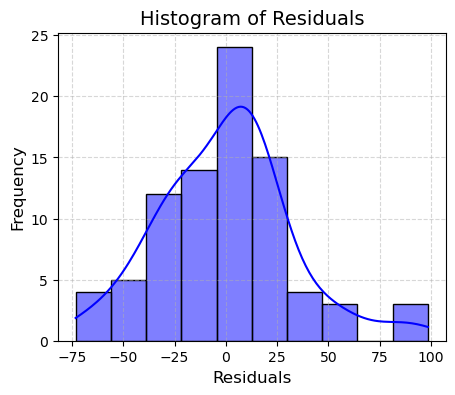

Final equation --> y = 332.00 + 38.72 * freq + -42.24 * freq^2


In [66]:
summary(res_order2_improved, final_features, X_test_neuron3, y_test_neuron3)

<Figure size 640x480 with 0 Axes>

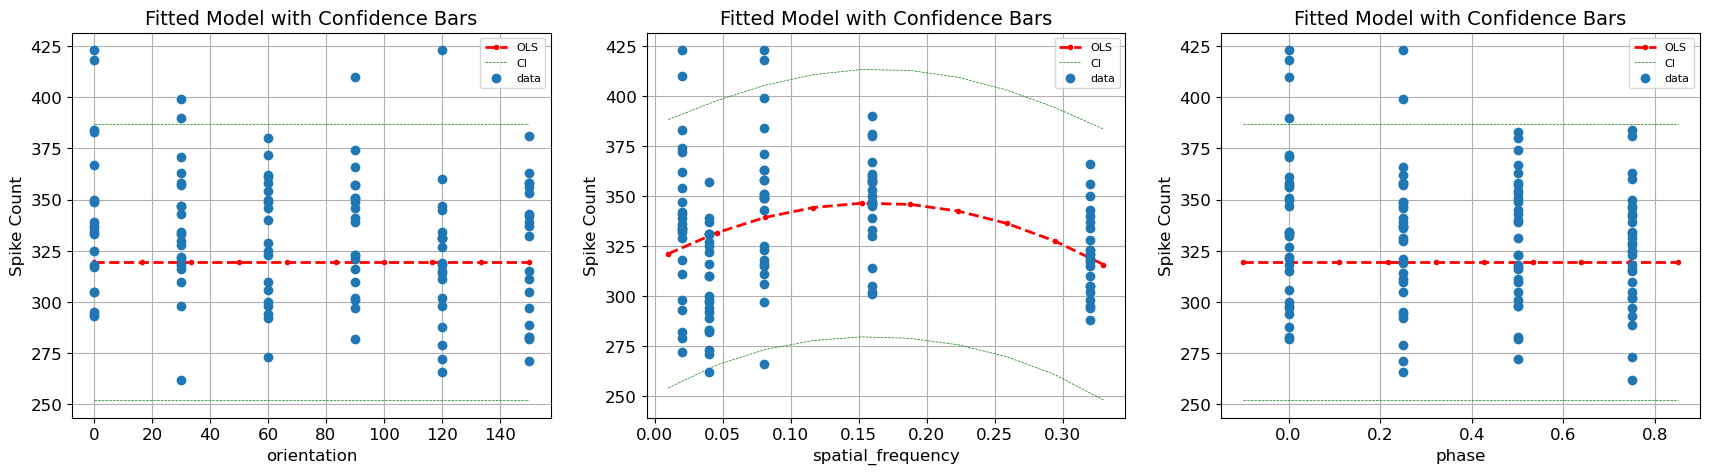

In [67]:
plot_regression_1D_all(df_neuron3, res_order2_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

The plot for the spatial frequency clearly shows the parabola, which shows how a quadratic term may be a better fit than the linear term.

### Sinusoidal Features

In [68]:
X_train_neuron3, X_test_neuron3, y_train_neuron3, y_test_neuron3 = get_data(df_neuron3, sinusoidal=True)
res_sinusoidal = OLS(y_train_neuron3, X_train_neuron3).fit()
print(res_sinusoidal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.556
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.172
Time:                        23:26:36   Log-Likelihood:                -409.93
No. Observations:                  84   AIC:                             833.9
Df Residuals:                      77   BIC:                             850.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        332.0126      3.657     90.794      0.0

In [69]:
final_features = backward_elimination(y_train_neuron3, X_train_neuron3)
print(f"Final model with significant features: {final_features}")
res_sinusoidal_improved = OLS(y_train_neuron3, X_train_neuron3[:, final_features]).fit()
print(res_sinusoidal_improved.summary())

Final model with significant features: [0, 3, 6]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.752
Date:                Tue, 30 Apr 2024   Prob (F-statistic):             0.0276
Time:                        23:26:41   Log-Likelihood:                -411.02
No. Observations:                  84   AIC:                             828.0
Df Residuals:                      81   BIC:                             835.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

R Squared: 0.085, Adjusted R Squared 0.062
Train RMSE: 33.933
Test RMSE: 30.649


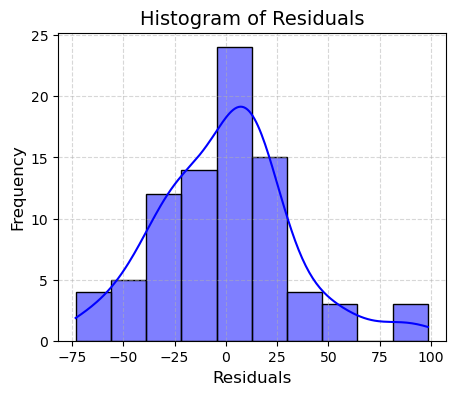

Final equation --> y = 332.00 + 37.93 * sin(freq) + 41.41 * cos(freq)


In [70]:
summary(res_sinusoidal_improved, final_features, X_test_neuron3, y_test_neuron3, sinusoidal = True)

<Figure size 640x480 with 0 Axes>

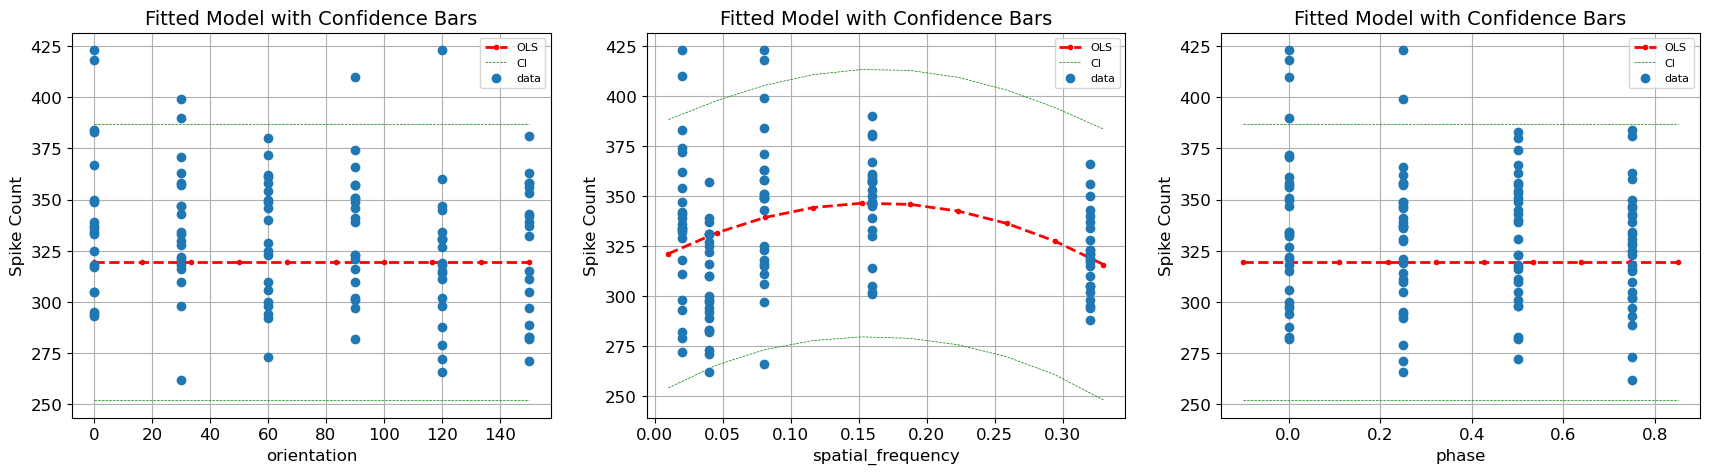

In [71]:
plot_regression_1D_all(df_neuron3, res_sinusoidal_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, sinusoidal=True)

### Combined Features

In [72]:
X_train_neuron3, X_test_neuron3, y_train_neuron3, y_test_neuron3 = get_data(df_neuron3, order=2, combined=True)
res_combined = OLS(y_train_neuron3, X_train_neuron3).fit()
print(res_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     2.153
Date:                Tue, 30 Apr 2024   Prob (F-statistic):             0.0188
Time:                        23:26:48   Log-Likelihood:                -399.51
No. Observations:                  84   AIC:                             829.0
Df Residuals:                      69   BIC:                             865.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        332.4515      3.435     96.773      0.0

Step down

In [73]:
final_features = backward_elimination(y_train_neuron3, X_train_neuron3)
print(f"Final model with significant features: {final_features}")
res_combined_improved = OLS(y_train_neuron3, X_train_neuron3[:, final_features]).fit()
print(res_combined_improved.summary())

Final model with significant features: [0, 3, 9, 12, 15]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     6.142
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           0.000235
Time:                        23:26:49   Log-Likelihood:                -403.36
No. Observations:                  84   AIC:                             816.7
Df Residuals:                      79   BIC:                             828.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

R Squared: 0.237, Adjusted R Squared 0.199
Train RMSE: 33.933
Test RMSE: 29.416


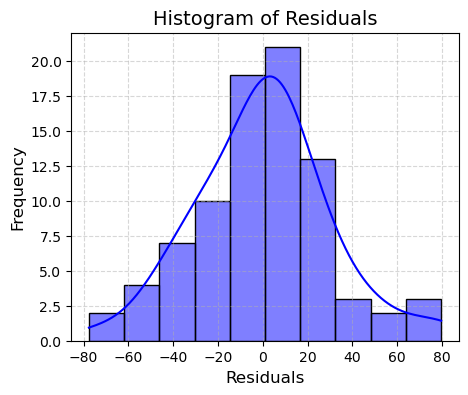

Final equation --> y = 332.70 + -487775.41 * freq + 591202.36 * freq^2 + 478077.08 * sin(freq) + 581040.10 * cos(freq)


In [74]:
summary(res_combined_improved, final_features, X_test_neuron3, y_test_neuron3)

<Figure size 640x480 with 0 Axes>

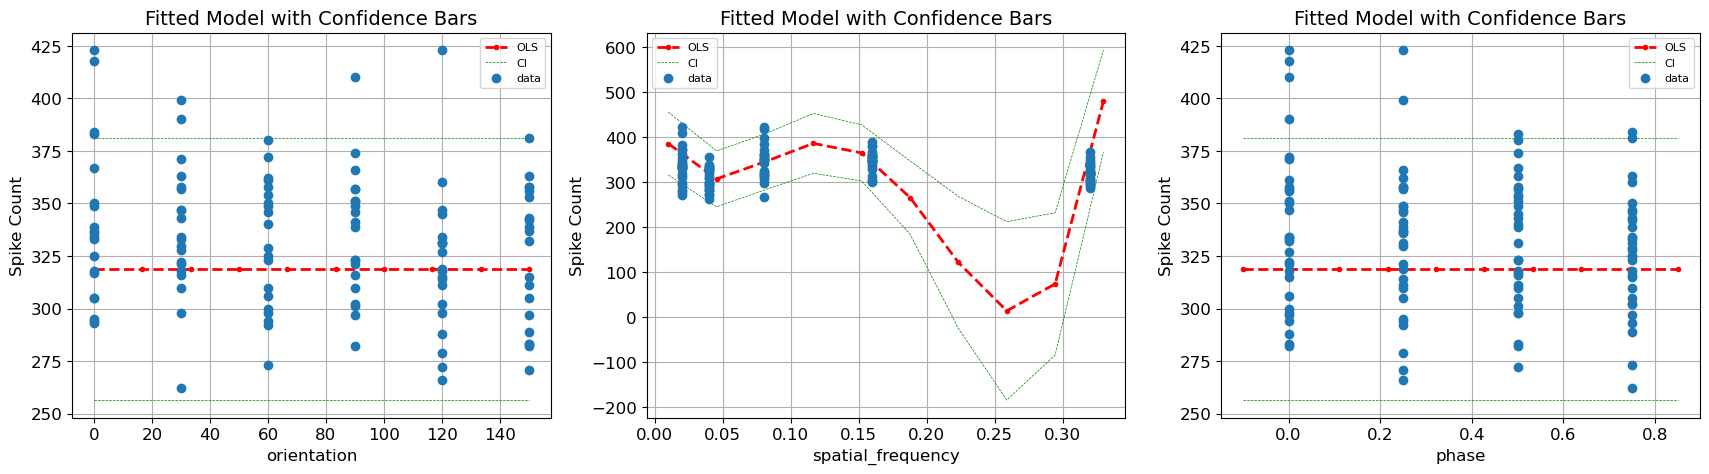

In [75]:
plot_regression_1D_all(df_neuron3, res_combined_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, order = 2, combined = True)

# Neuron 4

In [76]:
df_neuron4 = dfs[3]
df_neuron4

unit_id  spike_count  orientation  phase  spatial_frequency
3    951092949          297        150.0   0.50               0.02
8    951092949          266          0.0   0.50               0.16
13   951092949          253         30.0   0.25               0.04
18   951092949          267         60.0   0.75               0.04
23   951092949          255         60.0   0.00               0.08
..         ...          ...          ...    ...                ...
583  951092949          245        150.0   0.25               0.32
588  951092949          345         90.0   0.50               0.04
593  951092949          269          0.0   0.00               0.16
598  951092949          257         30.0   0.50               0.32
603  951092949          348         90.0   0.25               0.02

[120 rows x 5 columns]

## MLP

c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Epoch 1	Train loss: 287.79052734375	Test loss: 287.6818542480469
Epoch 2	Train loss: 287.3211364746094	Test loss: 287.5991516113281
Epoch 3	Train loss: 292.11961364746094	Test loss: 287.4596862792969
Epoch 4	Train loss: 298.26036071777344	Test loss: 287.1457214355469
Epoch 5	Train loss: 294.32525634765625	Test loss: 286.339111328125


Epoch 6	Train loss: 293.2937927246094	Test loss: 284.16156005859375
Epoch 7	Train loss: 285.01568603515625	Test loss: 278.3580017089844
Epoch 8	Train loss: 281.1006317138672	Test loss: 263.63409423828125
Epoch 9	Train loss: 261.573486328125	Test loss: 227.96841430664062
Epoch 10	Train loss: 215.05768585205078	Test loss: 147.5415496826172
Epoch 11	Train loss: 117.46306228637695	Test loss: 80.32718658447266
Epoch 12	Train loss: 109.25583267211914	Test loss: 102.23121643066406
Epoch 13	Train loss: 85.84740829467773	Test loss: 47.753414154052734
Epoch 14	Train loss: 63.61704444885254	Test loss: 67.58415985107422
Epoch 15	Train loss: 67.67150688171387	Test loss: 43.52535629272461
Epoch 16	Train loss: 47.87629508972168	Test loss: 56.42900466918945
Epoch 17	Train loss: 57.372365951538086	Test loss: 47.72617721557617
Epoch 18	Train loss: 42.0664005279541	Test loss: 45.17826461791992
Epoch 19	Train loss: 59.650718688964844	Test loss: 47.14894104003906
Epoch 20	Train loss: 50.49740791320801	Test

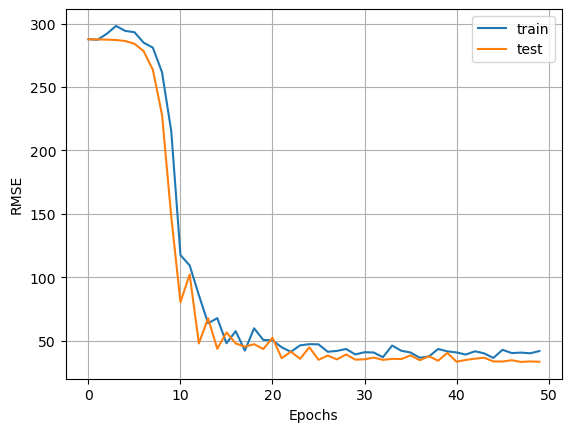

In [77]:
mlp_linear = run_mlp(df_neuron4)

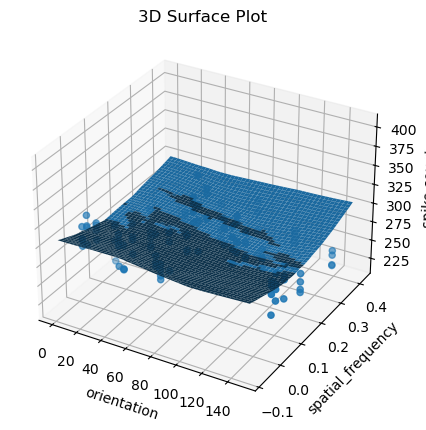

In [78]:
plot_regression_mlp_2D(df_neuron4, mlp_linear, 'orientation', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

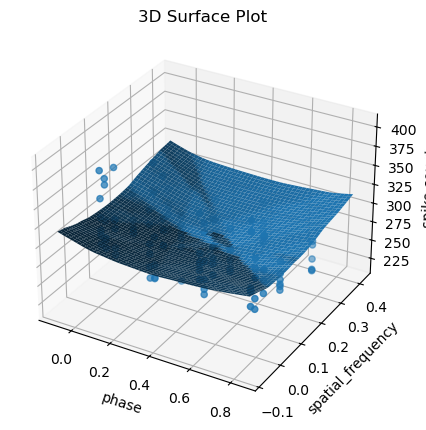

In [79]:
plot_regression_mlp_2D(df_neuron4, mlp_linear, 'phase', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

<Figure size 640x480 with 0 Axes>

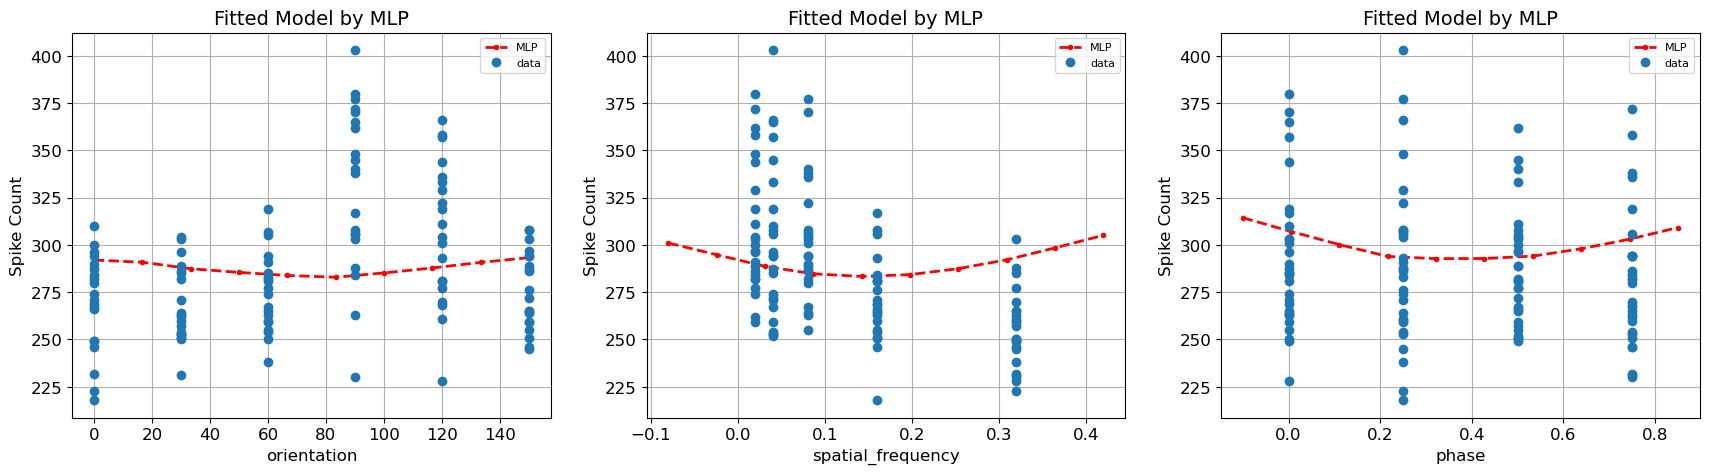

In [80]:
plot_regression_mlp_1D_all(df_neuron4, mlp_linear, orientation = 150, phase = 0.5, spatial_frequency= 0.32)

## Linear Regression

### First-Order Features

In [81]:
X_train_neuron4, X_test_neuron4, y_train_neuron4, y_test_neuron4 = get_data(df_neuron4)
res_order1 = OLS(y_train_neuron4, X_train_neuron4).fit()
print(res_order1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     17.59
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           7.35e-09
Time:                        23:27:19   Log-Likelihood:                -405.05
No. Observations:                  84   AIC:                             818.1
Df Residuals:                      80   BIC:                             827.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        289.8686      3.372     85.960      0.0

Step-down

In [82]:
final_features = backward_elimination(y_train_neuron4, X_train_neuron4)
print(f"Final model with significant features: {final_features}")
res_order1_improved = OLS(y_train_neuron4, X_train_neuron4[:, final_features]).fit()
print(res_order1_improved.summary())

Final model with significant features: [0, 1, 3]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     24.98
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           3.54e-09
Time:                        23:27:21   Log-Likelihood:                -406.15
No. Observations:                  84   AIC:                             818.3
Df Residuals:                      81   BIC:                             825.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

R Squared: 0.382, Adjusted R Squared 0.366
Train RMSE: 38.954
Test RMSE: 27.436


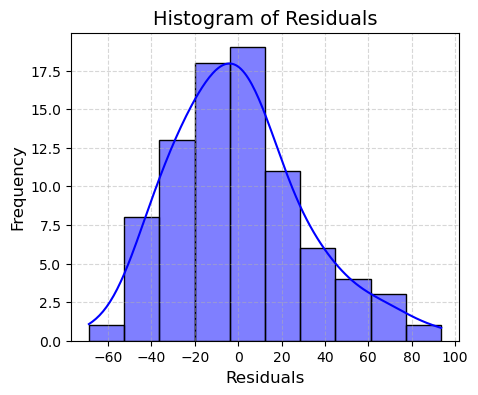

Final equation --> y = 289.62 + 12.33 * orient + -21.06 * freq


In [83]:
summary(res_order1_improved, final_features, X_test_neuron4, y_test_neuron4)

<Figure size 640x480 with 0 Axes>

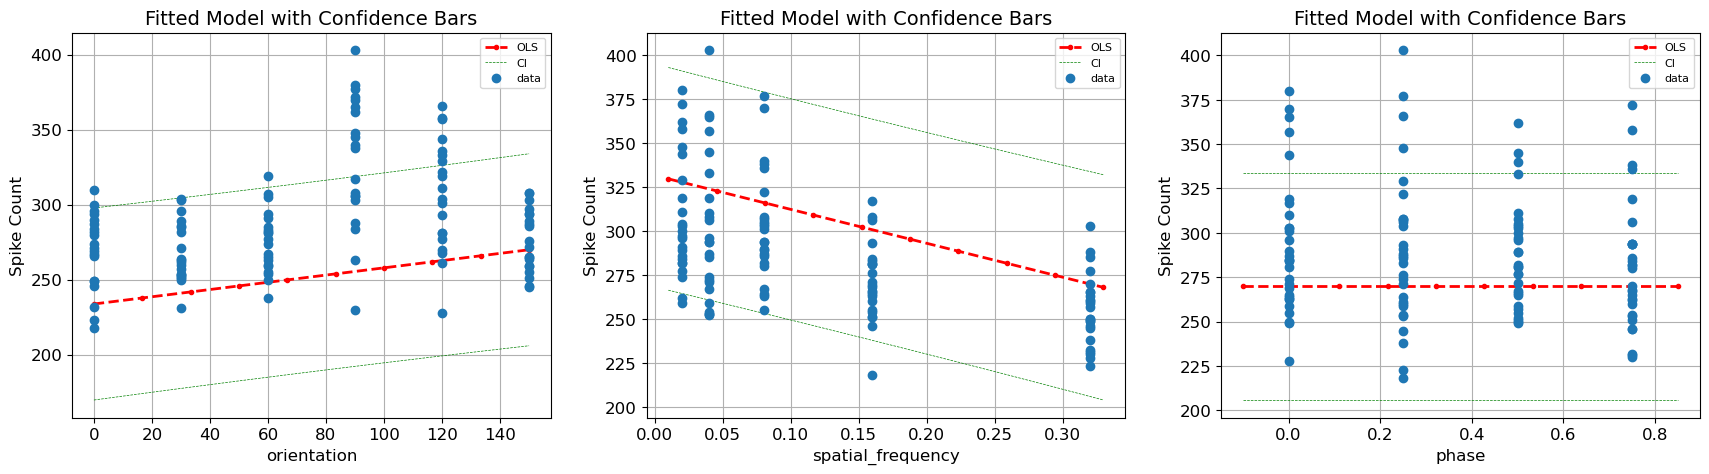

In [84]:
plot_regression_1D_all(df_neuron4, res_order1_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Quadratic Features

In [85]:
X_train_neuron4, X_test_neuron4, y_train_neuron4, y_test_neuron4 = get_data(df_neuron4, order=2)
res_order2 = OLS(y_train_neuron4, X_train_neuron4).fit()
print(res_order2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     9.412
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           2.15e-09
Time:                        23:27:25   Log-Likelihood:                -394.28
No. Observations:                  84   AIC:                             808.6
Df Residuals:                      74   BIC:                             832.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        289.5384      3.100     93.394      0.0

Step-down

In [86]:
final_features = backward_elimination(y_train_neuron4, X_train_neuron4)
print(f"Final model with significant features: {final_features}")
res_order2_improved = OLS(y_train_neuron4, X_train_neuron4[:, final_features]).fit()
print(res_order2_improved.summary())

Final model with significant features: [0, 1, 3, 4, 7]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     20.47
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           1.32e-11
Time:                        23:27:27   Log-Likelihood:                -396.45
No. Observations:                  84   AIC:                             802.9
Df Residuals:                      79   BIC:                             815.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.509, Adjusted R Squared 0.484
Train RMSE: 38.954
Test RMSE: 25.409


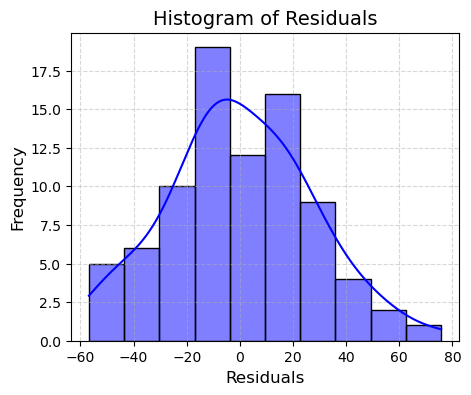

Final equation --> y = 289.59 + 53.33 * orient + -21.90 * freq + -44.47 * orient^2 + -6.08 * phase^2


In [87]:
summary(res_order2_improved, final_features, X_test_neuron4, y_test_neuron4)

<Figure size 640x480 with 0 Axes>

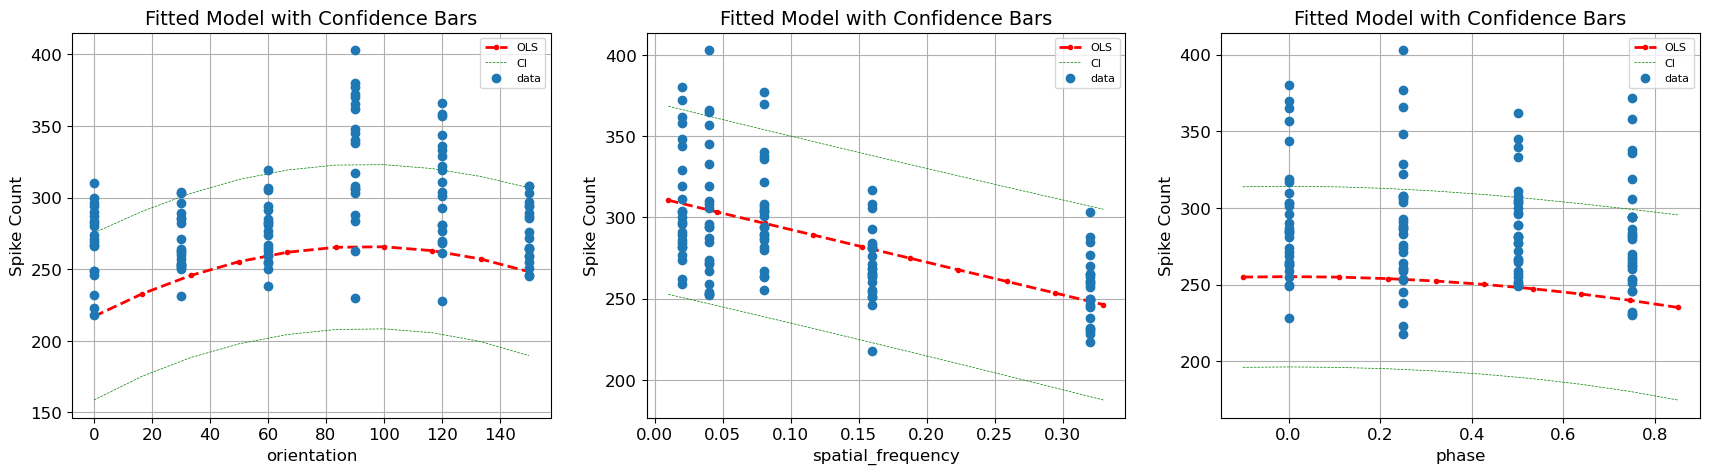

In [88]:
plot_regression_1D_all(df_neuron4, res_order2_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Sinusoidal Features

In [89]:
X_train_neuron4, X_test_neuron4, y_train_neuron4, y_test_neuron4 = get_data(df_neuron4, sinusoidal=True)
res_sinusoidal = OLS(y_train_neuron4, X_train_neuron4).fit()
print(res_sinusoidal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     25.84
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           1.32e-16
Time:                        23:27:31   Log-Likelihood:                -380.00
No. Observations:                  84   AIC:                             774.0
Df Residuals:                      77   BIC:                             791.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        287.3047      2.561    112.205      0.0

Step-down

In [90]:
final_features = backward_elimination(y_train_neuron4, X_train_neuron4)
print(f"Final model with significant features: {final_features}")
res_sinusoidal_improved = OLS(y_train_neuron4, X_train_neuron4[:, final_features]).fit()
print(res_sinusoidal_improved.summary())

Final model with significant features: [0, 1, 3, 4, 5]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     39.31
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           4.42e-18
Time:                        23:27:33   Log-Likelihood:                -380.32
No. Observations:                  84   AIC:                             770.6
Df Residuals:                      79   BIC:                             782.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.666, Adjusted R Squared 0.649
Train RMSE: 38.954
Test RMSE: 24.849


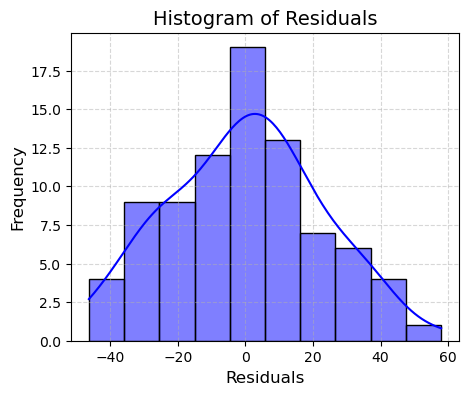

Final equation --> y = 287.47 + 21.54 * sin(orient) + -22.08 * sin(freq) + -5.30 * cos(orient) + 5.42 * cos(phase)


In [91]:
summary(res_sinusoidal_improved, final_features, X_test_neuron4, y_test_neuron4, sinusoidal = True)

<Figure size 640x480 with 0 Axes>

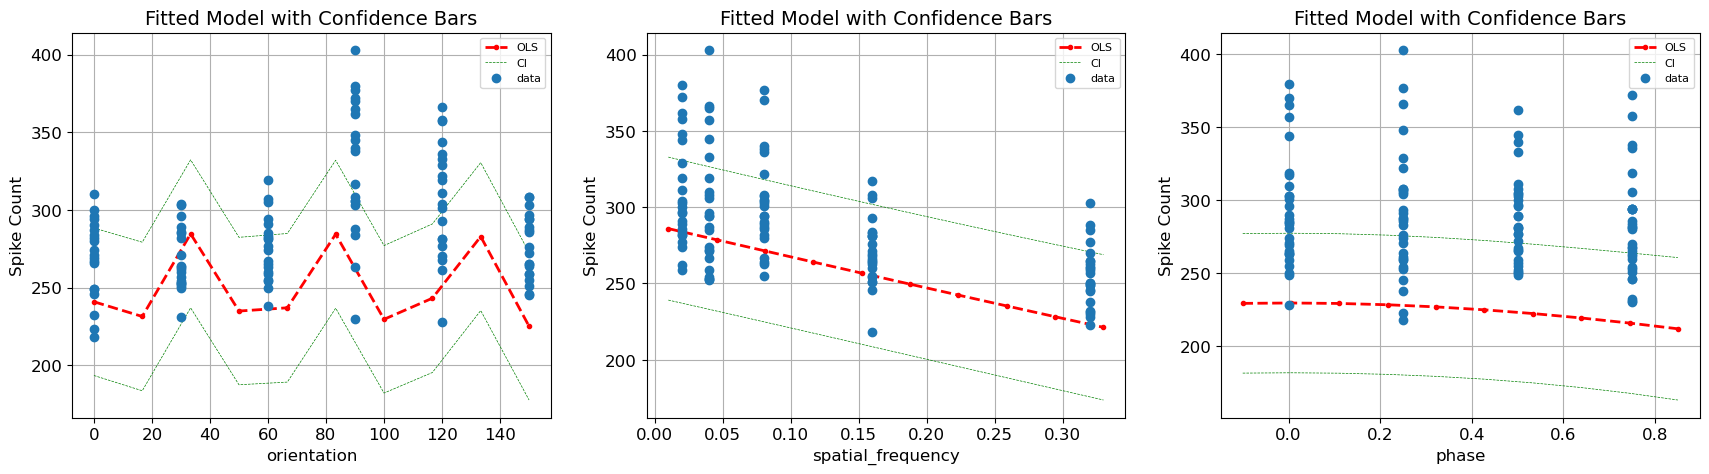

In [92]:
plot_regression_1D_all(df_neuron4, res_sinusoidal_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, sinusoidal=True)

### Combined Features

In [93]:
X_train_neuron4, X_test_neuron4, y_train_neuron4, y_test_neuron4 = get_data(df_neuron4, order=2, combined=True)
res_combined = OLS(y_train_neuron4, X_train_neuron4).fit()
print(res_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     13.92
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           5.74e-15
Time:                        23:27:36   Log-Likelihood:                -369.99
No. Observations:                  84   AIC:                             770.0
Df Residuals:                      69   BIC:                             806.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        288.1776      2.417    119.208      0.0

In [94]:
final_features = backward_elimination(y_train_neuron4, X_train_neuron4)
print(f"Final model with significant features: {final_features}")
res_combined_improved = OLS(y_train_neuron4, X_train_neuron4[:, final_features]).fit()
print(res_combined_improved.summary())

Final model with significant features: [0, 1, 2, 9, 10, 13, 15]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     31.42
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           8.22e-19
Time:                        23:27:37   Log-Likelihood:                -374.33
No. Observations:                  84   AIC:                             762.7
Df Residuals:                      77   BIC:                             779.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

R Squared: 0.710, Adjusted R Squared 0.687
Train RMSE: 38.954
Test RMSE: 23.394


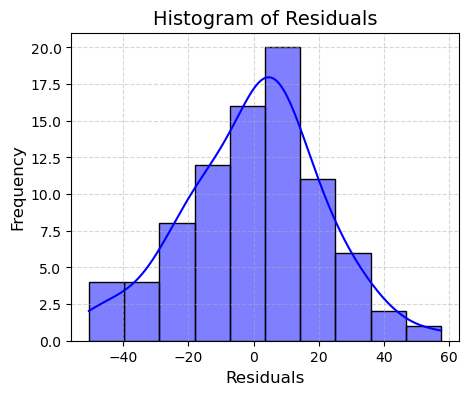

Final equation --> y = 288.10 + 7.80 * orient + -4.32 * phase + 4380.60 * freq^2 + 20.03 * sin(orient) + -5.24 * cos(orient) + 4402.08 * cos(freq)


In [95]:
summary(res_combined_improved, final_features, X_test_neuron4, y_test_neuron4)

<Figure size 640x480 with 0 Axes>

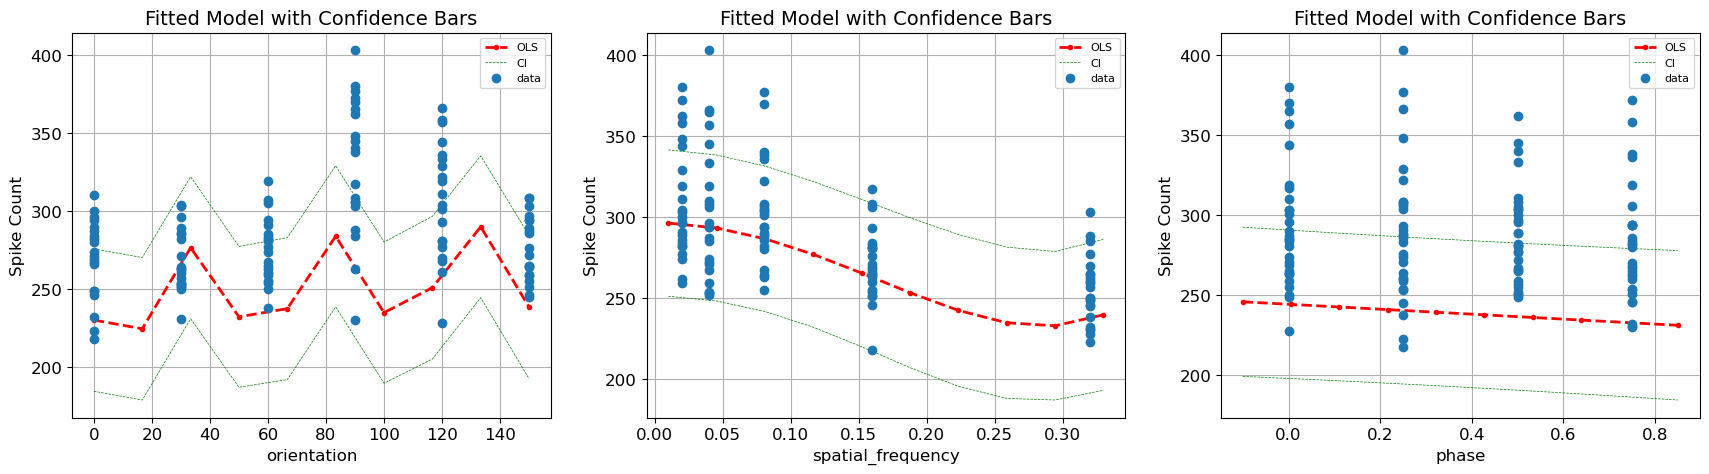

In [96]:
plot_regression_1D_all(df_neuron4, res_combined_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, order = 2, combined = True)

# Neuron 5

In [97]:
df_neuron5 = dfs[4]
df_neuron5

unit_id  spike_count  orientation  phase  spatial_frequency
4    951092973          270        150.0   0.50               0.02
9    951092973          341          0.0   0.50               0.16
14   951092973          315         30.0   0.25               0.04
19   951092973          281         60.0   0.75               0.04
24   951092973          342         60.0   0.00               0.08
..         ...          ...          ...    ...                ...
584  951092973          204        150.0   0.25               0.32
589  951092973          236         90.0   0.50               0.04
594  951092973          348          0.0   0.00               0.16
599  951092973          224         30.0   0.50               0.32
604  951092973          218         90.0   0.25               0.02

[120 rows x 5 columns]

## MLP

c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Epoch 1	Train loss: 290.8087921142578	Test loss: 286.14483642578125
Epoch 2	Train loss: 289.3103790283203	Test loss: 286.0647888183594
Epoch 3	Train loss: 290.66664123535156	Test loss: 285.9314270019531
Epoch 4	Train loss: 283.4877624511719	Test loss: 285.6340026855469
Epoch 5	Train loss: 292.5231475830078	Test loss: 284.8744201660156


Epoch 6	Train loss: 288.8618927001953	Test loss: 282.828369140625
Epoch 7	Train loss: 276.9119567871094	Test loss: 277.3746032714844
Epoch 8	Train loss: 280.1951599121094	Test loss: 263.5292053222656
Epoch 9	Train loss: 261.18048095703125	Test loss: 230.0189208984375
Epoch 10	Train loss: 223.0575408935547	Test loss: 155.40200805664062
Epoch 11	Train loss: 134.7625961303711	Test loss: 94.16844177246094
Epoch 12	Train loss: 122.41494369506836	Test loss: 124.0468978881836
Epoch 13	Train loss: 105.46077728271484	Test loss: 71.33776092529297
Epoch 14	Train loss: 80.69500732421875	Test loss: 92.07686614990234
Epoch 15	Train loss: 98.907470703125	Test loss: 85.29767608642578
Epoch 16	Train loss: 78.99946975708008	Test loss: 64.94481658935547
Epoch 17	Train loss: 68.4454231262207	Test loss: 89.91651153564453
Epoch 18	Train loss: 82.5091438293457	Test loss: 70.47077178955078
Epoch 19	Train loss: 69.45294952392578	Test loss: 72.21985626220703
Epoch 20	Train loss: 82.22885513305664	Test loss: 73.

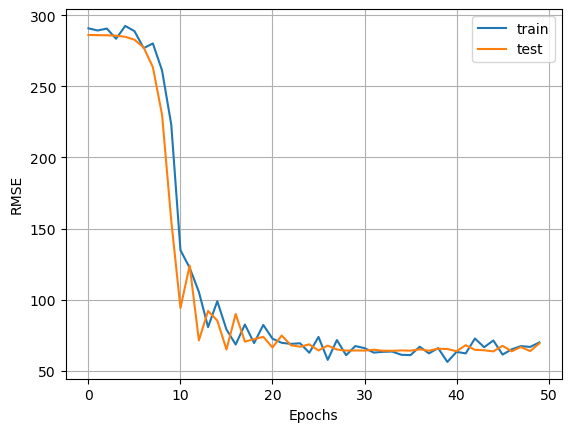

In [98]:
mlp_linear = run_mlp(df_neuron5)

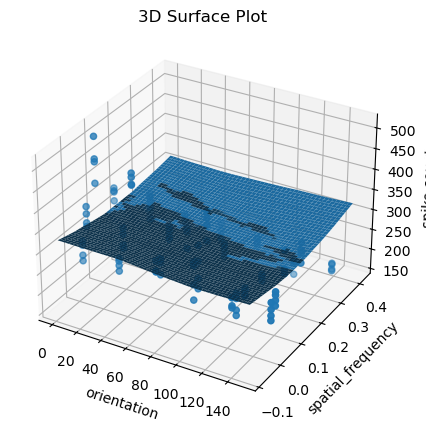

In [99]:
plot_regression_mlp_2D(df_neuron5, mlp_linear, 'orientation', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

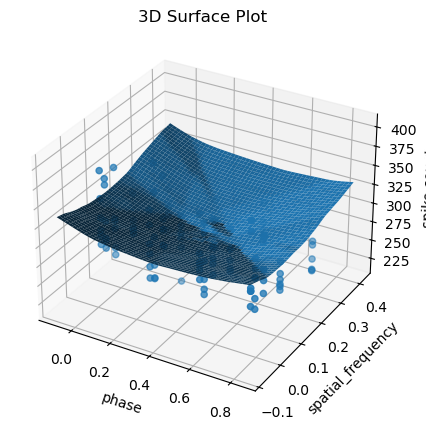

In [100]:
plot_regression_mlp_2D(df_neuron4, mlp_linear, 'phase', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

<Figure size 640x480 with 0 Axes>

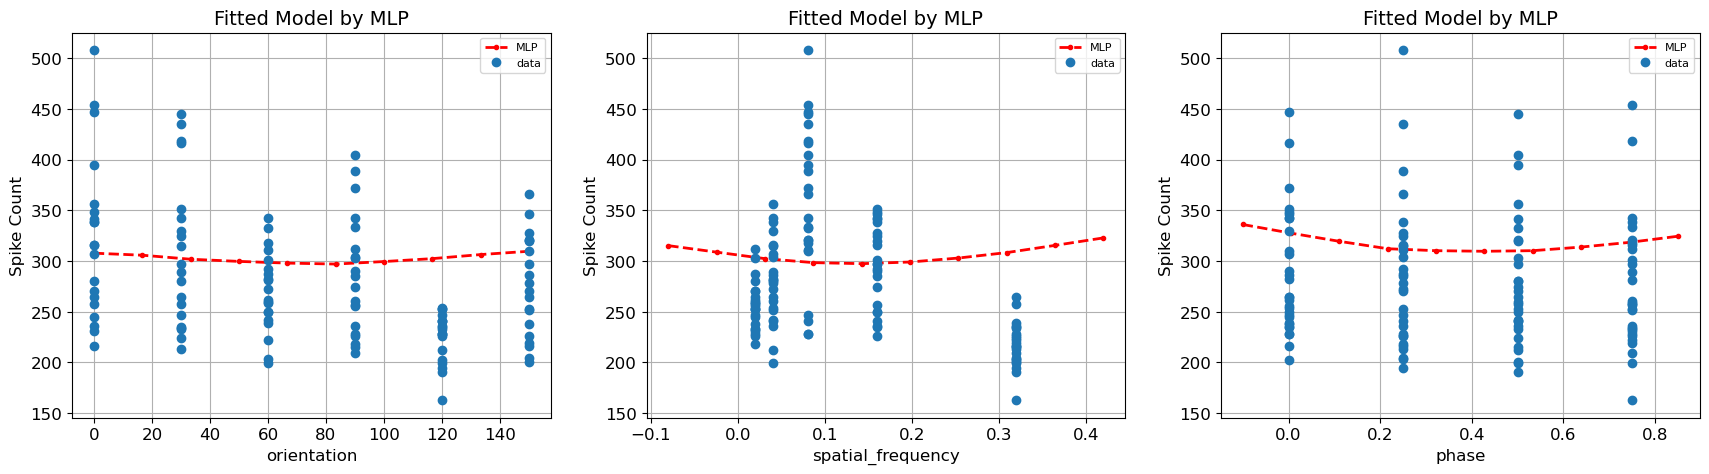

In [101]:
plot_regression_mlp_1D_all(df_neuron5, mlp_linear, orientation = 150, phase = 0.5, spatial_frequency= 0.32)

## Linear Regression

### First-Order Features

In [102]:
X_train_neuron5, X_test_neuron5, y_train_neuron5, y_test_neuron5 = get_data(df_neuron5)
res_order1 = OLS(y_train_neuron5, X_train_neuron5).fit()
print(res_order1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     8.908
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           3.67e-05
Time:                        23:28:05   Log-Likelihood:                -457.15
No. Observations:                  84   AIC:                             922.3
Df Residuals:                      80   BIC:                             932.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        281.4425      6.270     44.889      0.0

In [103]:
final_features = backward_elimination(y_train_neuron5, X_train_neuron5)
print(f"Final model with significant features: {final_features}")
res_order1_improved = OLS(y_train_neuron5, X_train_neuron5[:, final_features]).fit()
print(res_order1_improved.summary())

Final model with significant features: [0, 1, 3]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     13.49
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           8.75e-06
Time:                        23:28:06   Log-Likelihood:                -457.18
No. Observations:                  84   AIC:                             920.4
Df Residuals:                      81   BIC:                             927.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

R Squared: 0.250, Adjusted R Squared 0.231
Train RMSE: 64.938
Test RMSE: 53.845


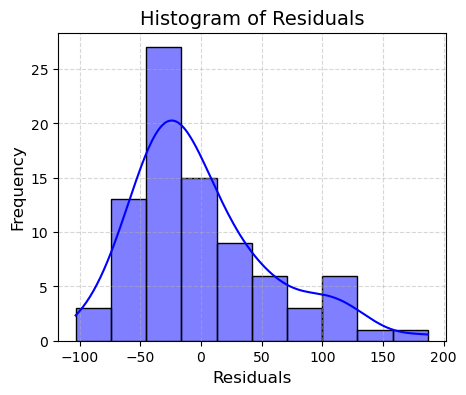

Final equation --> y = 281.37 + -20.27 * orient + -24.45 * freq


In [104]:
summary(res_order1_improved, final_features, X_test_neuron5, y_test_neuron5)

<Figure size 640x480 with 0 Axes>

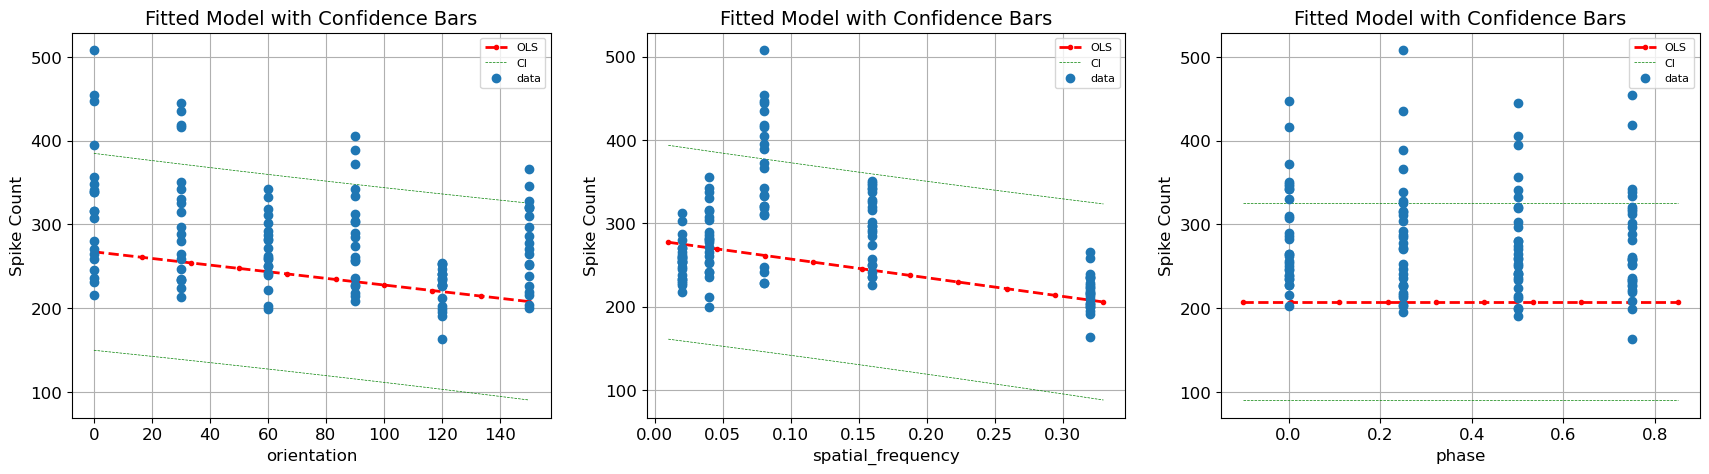

In [105]:
plot_regression_1D_all(df_neuron5, res_order1_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Quadratic Features

In [106]:
X_train_neuron5, X_test_neuron5, y_train_neuron5, y_test_neuron5 = get_data(df_neuron5, order=2)
res_order2 = OLS(y_train_neuron5, X_train_neuron5).fit()
print(res_order2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     8.413
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           1.56e-08
Time:                        23:28:10   Log-Likelihood:                -439.66
No. Observations:                  84   AIC:                             899.3
Df Residuals:                      74   BIC:                             923.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3736      5.321     52.691      0.0

In [107]:
final_features = backward_elimination(y_train_neuron5, X_train_neuron5)
print(f"Final model with significant features: {final_features}")
res_order2_improved = OLS(y_train_neuron5, X_train_neuron5[:, final_features]).fit()
print(res_order2_improved.summary())

Final model with significant features: [0, 1, 3, 9]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     24.59
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           2.25e-11
Time:                        23:28:10   Log-Likelihood:                -441.81
No. Observations:                  84   AIC:                             891.6
Df Residuals:                      80   BIC:                             901.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


R Squared: 0.480, Adjusted R Squared 0.460
Train RMSE: 64.938
Test RMSE: 44.067


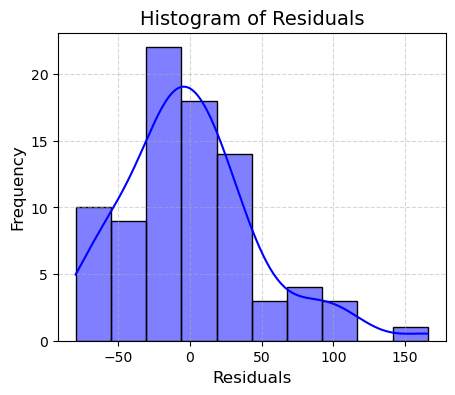

Final equation --> y = 280.65 + -21.55 * orient + 110.92 * freq + -138.25 * freq^2


In [108]:
summary(res_order2_improved, final_features, X_test_neuron5, y_test_neuron5)

<Figure size 640x480 with 0 Axes>

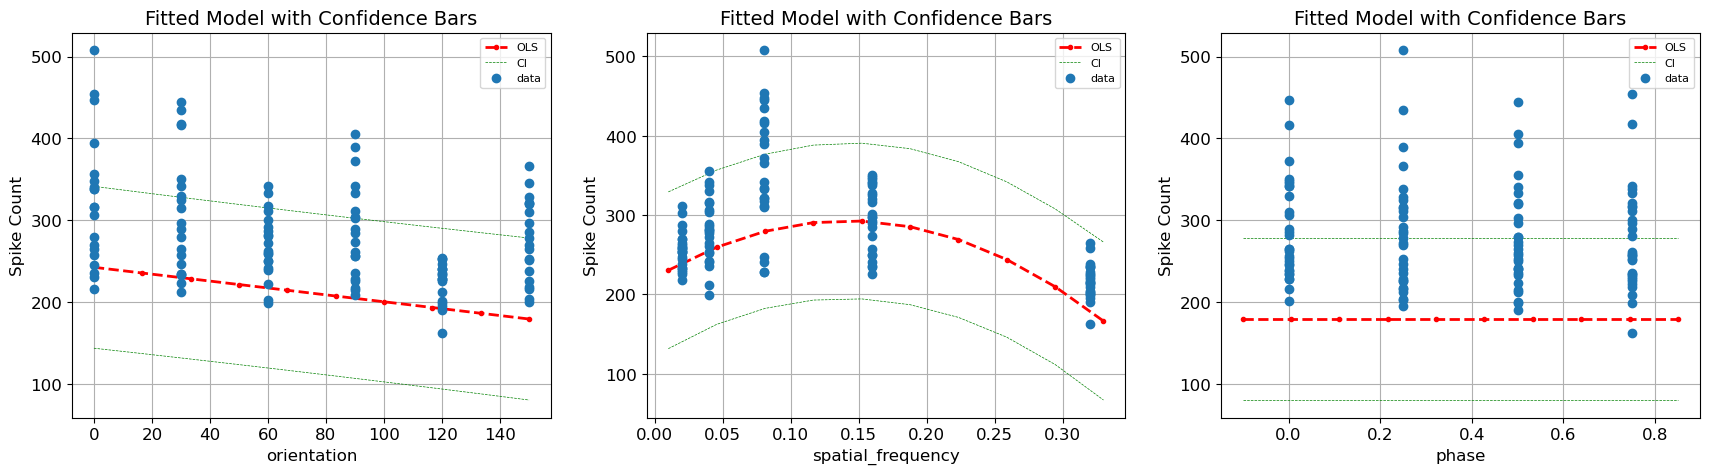

In [109]:
plot_regression_1D_all(df_neuron5, res_order2_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Sinusoidal Features

In [110]:
X_train_neuron5, X_test_neuron5, y_train_neuron5, y_test_neuron5 = get_data(df_neuron5, sinusoidal=True)
res_sinusoidal = OLS(y_train_neuron5, X_train_neuron5).fit()
print(res_sinusoidal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     9.012
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           1.87e-07
Time:                        23:28:14   Log-Likelihood:                -446.91
No. Observations:                  84   AIC:                             907.8
Df Residuals:                      77   BIC:                             924.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        282.6292      5.679     49.763      0.0

In [111]:
final_features = backward_elimination(y_train_neuron5, X_train_neuron5)
print(f"Final model with significant features: {final_features}")
res_sinusoidal_improved = OLS(y_train_neuron5, X_train_neuron5[:, final_features]).fit()
print(res_sinusoidal_improved.summary())

Final model with significant features: [0, 1, 3, 6]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     17.96
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           5.29e-09
Time:                        23:28:14   Log-Likelihood:                -447.63
No. Observations:                  84   AIC:                             903.3
Df Residuals:                      80   BIC:                             913.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


R Squared: 0.402, Adjusted R Squared 0.380
Train RMSE: 64.938
Test RMSE: 49.765


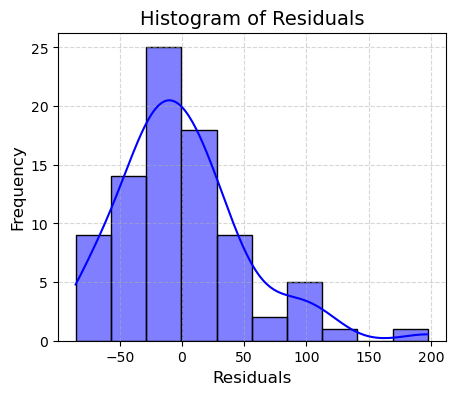

Final equation --> y = 282.89 + -11.44 * sin(orient) + 101.85 * sin(freq) + 129.20 * cos(freq)


In [112]:
summary(res_sinusoidal_improved, final_features, X_test_neuron5, y_test_neuron5, sinusoidal = True)

<Figure size 640x480 with 0 Axes>

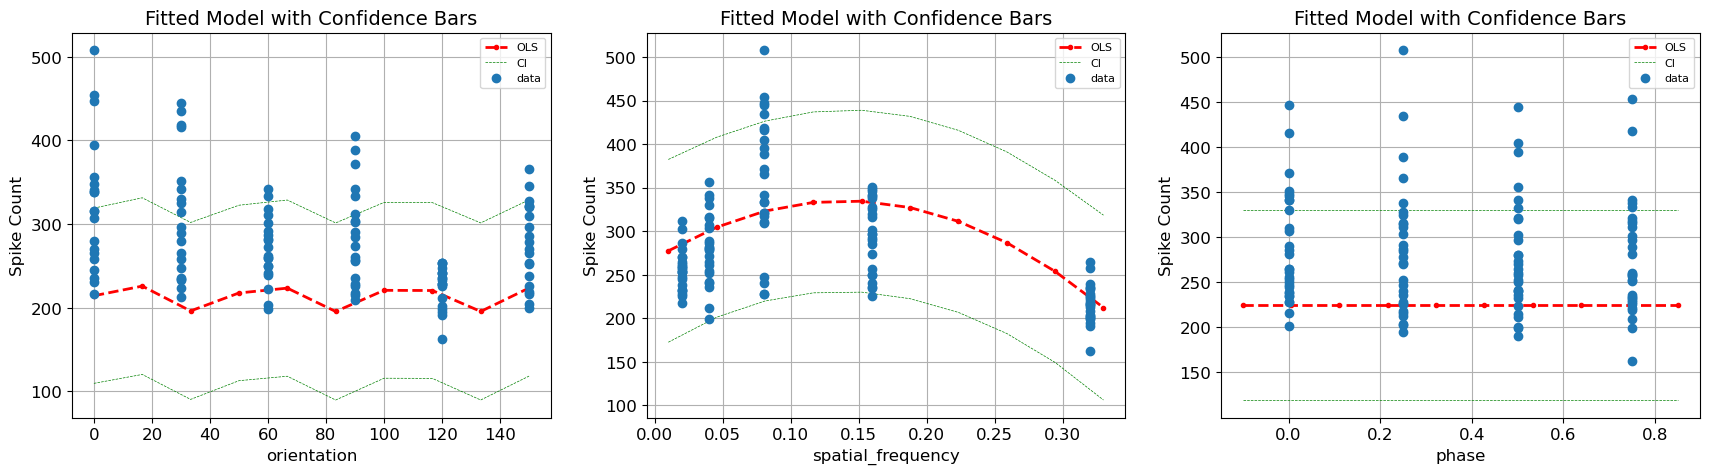

In [113]:
plot_regression_1D_all(df_neuron5, res_sinusoidal_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, sinusoidal=True)

### Combined Features

In [114]:
X_train_neuron5, X_test_neuron5, y_train_neuron5, y_test_neuron5 = get_data(df_neuron5, order=2, combined=True)
res_combined = OLS(y_train_neuron5, X_train_neuron5).fit()
print(res_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     10.67
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           2.50e-12
Time:                        23:28:18   Log-Likelihood:                -420.86
No. Observations:                  84   AIC:                             871.7
Df Residuals:                      69   BIC:                             908.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.8152      4.429     63.402      0.0

In [115]:
final_features = backward_elimination(y_train_neuron5, X_train_neuron5)
print(f"Final model with significant features: {final_features}")
res_combined_improved = OLS(y_train_neuron5, X_train_neuron5[:, final_features]).fit()
print(res_combined_improved.summary())

Final model with significant features: [0, 1, 3, 4, 9, 12, 13, 15]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     21.82
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           7.36e-16
Time:                        23:28:19   Log-Likelihood:                -422.98
No. Observations:                  84   AIC:                             862.0
Df Residuals:                      76   BIC:                             881.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

R Squared: 0.668, Adjusted R Squared 0.637
Train RMSE: 64.938
Test RMSE: 28.501


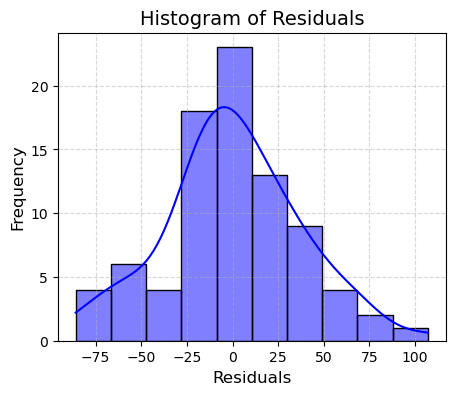

Final equation --> y = 280.76 + -113.99 * orient + -377505.48 * freq + 96.93 * orient^2 + 511393.99 * freq^2 + 370432.48 * sin(freq) + -21.33 * cos(orient) + 503975.88 * cos(freq)


In [116]:
summary(res_combined_improved, final_features, X_test_neuron5, y_test_neuron5)

<Figure size 640x480 with 0 Axes>

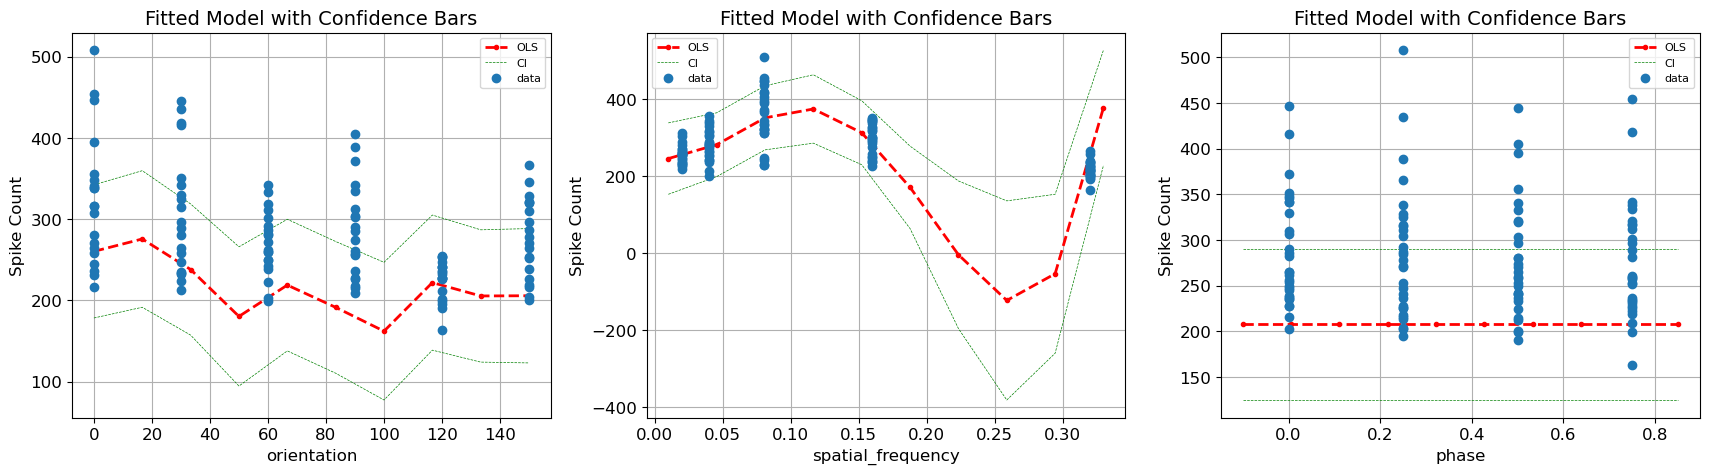

In [117]:
plot_regression_1D_all(df_neuron5, res_combined_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, order = 2, combined = True)

# Comments

## MLP

All networks trained for 50 epochs, hidden layers size 64-128-256-512-1024-256-64, RMSE loss, AdamW with weight decay value 0.025 and LeakyReLU activation

- Neuron 1 --> Train loss: 74.54, Test loss: 63.14
- Neuron 2 --> Train loss: 83.07, Test loss: 67.53
- Neuron 3 --> Train loss: 34.19, Test loss: 32.53
- Neuron 4 --> Train loss: 41.71, Test loss: 33.27
- Neuron 5 --> Train loss: 69.90, Test loss: 69.23

Comments:
- Graphically we see that mlp performs poorly and is not able to fully capture the nonlinearity of the data.
- The variability in the losses can be due to the data.
- Test loss is lower than train loss probably because of samples in the test set, which was chosen randomly.
- The loss values here are comparable to those obtained in the regressions. Both the mlp and the regression minimize the same loss, so "loss results" will be similar.


## Regressions


We always checked the normality of the residuals to assert the assumptions of linear regression were satisfied. We always normalized the data. We do model selection via step-down. Maximum significance level is taken as 0.1


NOTICE: all train losses within neurons are the same.... mhhh

**Neuron 1**
- linear:
    - $y = 189.41  -23.61  orient  -15.94  freq$
    - R Squared: 0.172, Adjusted R Squared 0.152, Train RMSE: 69.974, Test RMSE: 58.346
    - low r2, graphically looks bad and it doesn't capture the increasing tendency of the spatial frequency for low values

- quadratic:
    - $y = 189.07  -86.86  orient + 104.79 freq + 66.83  orient^2  -122.02  freq^2$
    - R Squared: 0.394, Adjusted R Squared 0.363, Train RMSE: 69.974, Test RMSE: 48.821
    - same terms as linear but with added quadratic terms... may be a sign of overfitting, also given that test is very low. still nonlinearity seems to be better than linear, since the trends match the data better than before

- sin:
    - $y = 192.30  -27.26 \ sin(orient) + 91.98 \ sin(freq) + 14.49 \ cos(orient) + 108.72 \ cos(freq)$
    - R Squared: 0.416, Adjusted R Squared 0.387, Train RMSE: 69.974, Test RMSE: 54.102
    - higher test loss, so probably less overfitting and better generalization. better r2. the plots seems nicer, especially for the spatial frequency

- combined:
    - $y = 189.57 + 44407.51 freq  -30.94 orient^2 + 17.31 (orient * freq) -1377.48 freq^2  -26.22 \sin(orient) +-43090.47 \sin(freq) + 21.86 \cos(orient)$
    - R Squared: 0.663, Adjusted R Squared 0.632, Train RMSE: 69.974, Test RMSE: 41.440
    - very long expression, so less interpretable than the other one. higher r2 than before. graphically seems good.  orientation is now oscillatory. plot for spatial frequency is similar to before in the left part, but then oscillates. we can't conclude whether it's actually sinusoidal, but it seems like a good fit and scientifically reasonable.

Overall comments: phase is never considered (so it's statistically irrelevant). there are always big confideence values. this is due to the high variability of data in single points. this also implies that the loss has a natural lower bound, and can't go below specific values because there will always be far values from the predicted point.

**Neuron 2**
- linear:
    - $y = 142.06 + 16.69 orient$
    - R Squared: 0.048, Adjusted R Squared 0.037, Train RMSE: 75.899, Test RMSE: 70.076
    - it captures the increasing factor in the orientation. other than that it's bad. frequency is not relevant.

- quadratic:
    - $y = 141.23 + 146.19  orient + 59.97  freq -139.62  orient^2  -74.13 freq^2$
    - R Squared: 0.388, Adjusted R Squared 0.357, Train RMSE: 75.899, Test RMSE: 57.623, 
    - same structure as in neuron 1 (similar comments to before). now freqeuncy plays a role and fits the data not badly.

- sin:
    - $y = 137.55 + 45.94 \sin(orient) + 71.90 \sin(freq)  -27.10 \cos(orient) + 87.30 \cos(freq)$
    - R Squared: 0.631, Adjusted R Squared 0.612, Train RMSE: 75.899, Test RMSE: 45.219,
    - way better r2, lower test loss. all features are present so it may be overfitting(?). spatial frequency seems worse than before. orientation slightly better since the OLS peaks close to where the actual peak in the data is.

- combined:
    - $y = 136.78 + 39545.36  freq -1212.05  freq^2 + 45.54 \sin(orient) -38377.74 \sin(freq) -26.66 \cos(orient)$
    - R Squared: 0.736, Adjusted R Squared 0.719, Train RMSE: 75.899, Test RMSE: 38.024
    - high r2, low test loss. graphically seems good, but similar comments to combined in neuron 1

Overall comments: again phase is not considered by the models.

Now that i think about it, the concept of overfitting here doesn't make much sense, since the data is distributed along vertical lines... so it the tendency of having low test loss really due to the data? or is there some other factor we're not considering.

**Neuron 3**
- linear:
    - no result

- quadratic:
    - $y = 332.00 + 38.72  freq  -42.24 freq^2$
    - R Squared: 0.085, Adjusted R Squared 0.062, Train RMSE: 33.933, Test RMSE: 30.649
    - only frequency is relevant. doesn't look good.

- sin:
    - $y = 332.00 + 37.93 \sin(freq) + 41.41 \cos(freq)$
    - R Squared: 0.085, Adjusted R Squared 0.062, Train RMSE: 33.933, Test RMSE: 30.649
    - similar results to quadratic features (actually the same). again only frequency. plot still doesn't look good.

- combined:
    - $y = 332.70 + -487775.41  freq + 591202.36 freq^2 + 478077.08 \sin(freq) + 581040.10 \cos(freq)$
    - R Squared: 0.237, Adjusted R Squared 0.199, Train RMSE: 33.933, Test RMSE: 29.416
    - Increased r2. again only frequency. doesn't generalize well, since there is big downwards trough which is surely not physically logical.

Overall comments: here it didn't go well, compared to the other neurons. frequency seems to be the only statistically significant variable.

**Neuron 4**
- linear:
    - $y = 289.62 + 12.33 orient -21.06  freq$
    - R Squared: 0.382, Adjusted R Squared 0.366, Train RMSE: 38.954, Test RMSE: 27.436
    - captures overall tendencies. still, improvements can be made by including the nonlinearities.

- quadratic:
    - $y = 289.59 + 53.33 orient -21.90 freq -44.47 orient^2 -6.08 phase^2$
    - R Squared: 0.509, Adjusted R Squared 0.484, Train RMSE: 38.954, Test RMSE: 25.409
    - improved compared to before, but lower test loss (same issues as before). model is same as linear but with added terms in orientation and phase. it seems good graphically, but the measurement data make it hard to find a good fit.

- sin:
    - $y = 287.47 + 21.54  \sin(orient) -22.08 \sin(freq) -5.30 \cos(orient) + 5.42 \cos(phase)$
    - R Squared: 0.666, Adjusted R Squared 0.649, Train RMSE: 38.954, Test RMSE: 24.849 
    - increased r2, lower test loss again. phase seems significant again. even though there is a sin(freq) from the plots is looks linear, indeed $\sin x\approx x$ for small values, so it makes sense, since frequency values are small. phase is similar. orientation now is oscillating. we cannot know if that ideal...

- combined:
    - $y = 288.10 + 7.80 orient  -4.32 phase + 4380.60 freq^2 + 20.03 \sin(orient) -5.24 \cos(orient) + 4402.08 \cos(freq)$
    - R Squared: 0.710, Adjusted R Squared 0.687, Train RMSE: 38.954, Test RMSE: 23.394
    - even lower test loss and incresed r2. graphically it seems like the best one, especially for frequency. 

overall commments: only model in which phase has appeared so far.

**Neuron 5**
- linear:
    - $y = 281.37 -20.27 orient -24.45 freq$
    - R Squared: 0.250, Adjusted R Squared 0.231, Train RMSE: 64.938, Test RMSE: 53.845
    - completely wrong, especially for frequency

- quadratic:
    - $y = 280.65 -21.55  orient + 110.92 freq  -138.25 freq^2$
    - R Squared: 0.480, Adjusted R Squared 0.460, Train RMSE: 64.938, Test RMSE: 44.067
    - new is only quadratic term in the frequency, which improves the r2 and also the plot.

- sin:
    - $y = 282.89 -11.44 \sin(orient) + 101.85 \sin(freq) + 129.20 \cos(freq)$
    - R Squared: 0.402, Adjusted R Squared 0.380, Train RMSE: 64.938, Test RMSE: 49.765
    - worse than quadratic in r2, orientation now is oscillating, but in a range of very low spike counts, indicating that the effect may not be that relevant. the fit for spatial frequency seems improved.

- combined:
    - $y = 280.76 -113.99 orient -377505.48 freq + 96.93 orient^2 + 511393.99  freq^2 + 370432.48 \sin(freq) -21.33 \cos(orient) + 503975.88 \cos(freq)$
    - R Squared: 0.668, Adjusted R Squared 0.637, Train RMSE: 64.938, Test RMSE: 28.501
    - best r2 and lowest test loss in this neuron. orientation still oscillates like before. now instead frequency has a low trough, which seems bad. This, added to the fact that frequency has linear, quadratic and sinusoidal terms may indicate some sort of overfitting in that variable.

**GENERAL COMMENTS**

overall phase is not important. linear features don't tend to capture the true correlations (as expected). a combination of quadratic and sinusoidal terms seems to be the best performing. "physical fine-tuning" (i.e. modifiying the model (or even the input feature) to match known neuroscientific results) would be needed to improve the results. other pefromance metrics other than r2 and rsme could be used, maybe more prone to neuroscience. the confidence intervals are very large, so even though the model are statistically significant, there is still high variability. 